# Telecom Churn Prediction

# 0. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [ ]:
#Data Structures
import pandas as pd
import numpy as np
import re

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables.

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [ ]:

data = pd.read_csv("/content/train.csv")
unseen = pd.read_csv("/content/test.csv")
sample = pd.read_csv("/content/sample.csv")
data_dict = pd.read_csv("/content/data_dictionary.csv")

print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


In [ ]:
data_dict

,Acronyms,Description
0,CIRCLE_ID,Telecom circle area to which the customer belo...
1,LOC,Local calls within same telecom circle
2,STD,STD calls outside the calling circle
3,IC,Incoming calls
4,OG,Outgoing calls
5,T2T,Operator T to T ie within same operator mobile...
6,T2M,Operator T to other operator mobile
7,T2O,Operator T to other operator fixed line
8,T2F,Operator T to fixed lines of T
9,T2C,Operator T to its own call center


Next Steps to be followed:
- Data understanding
- Data cleaning
- Standardizing the data and splitting
- Feature engineering
- Build the predictive model
- Check the prediction score and accuracy for train and test data

# STEP 2 DATA UNDERSTANDING

In [ ]:
# Adding few settings to view max number of rows and columns:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
#Created a function to calculate the null value percentage present in each column
def null_value_percentage(data):
    dataframe= data.copy()
    missing = pd.DataFrame(100*dataframe.isnull().sum()/len(dataframe.index))
    return missing

In [ ]:
#Created a function to calculate the number of unique values in each column:
def unique_values(df):
  return df.nunique()


In [ ]:
telecom_df = pd.read_csv('train.csv')
telecom_df.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.0,0.00,0.0,0.0,0.0,0.0,0.0,65.09,204.99,1.01,0.0,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.0,0.0,0.0,0.0,0.0,0.0,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.0,0.0,0.0,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.00,0.0,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/2014,7/10/2014,8/26/2014,0,0,0,NaN,7/8/2014,NaN,NaN,1.0,NaN,NaN,145.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,Na

In [ ]:
telecom_df.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

In [ ]:
telecom_df.describe(include="all")

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.000000,69999.0,69297.0,69297.0,69297.0,69999,69600,69266,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.0,67312.0,66296.0,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.0,67312.0,66296.0,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,68898,68765,67538,69999.000000,69999.000000

In [ ]:
data_type_counts = telecom_df.dtypes.value_counts()
print(data_type_counts)


float64    135
int64       28
object       9
Name: count, dtype: int64


In [ ]:
null_value_percentage(telecom_df)

,0
id,0.000000
circle_id,0.000000
loc_og_t2o_mou,1.002871
std_og_t2o_mou,1.002871
loc_ic_t2o_mou,1.002871
last_date_of_month_6,0.000000
last_date_of_month_7,0.570008
last_date_of_month_8,1.047158
arpu_6,0.000000
arpu_7,0.000000


In [ ]:
# Calculate null value percentages
null_percentages = null_value_percentage(telecom_df)

# Filter columns with more than 30% null values
columns_above_30 = null_percentages[null_percentages > 30]

# Extract the percentages and remove NaNs
percentages_above_30 = columns_above_30.dropna().values.flatten()

# Print the percentages
print("Percentages above 30%:", percentages_above_30)

# Count the number of columns above the threshold
num_columns_above_30 = len(percentages_above_30)
print(f"\nNumber of columns with more than 30% null values: {num_columns_above_30}")

Percentages above 30%: [74.90249861 74.47820683 73.68962414 74.90249861 74.47820683 73.68962414
 74.90249861 74.47820683 73.68962414 74.90249861 74.47820683 73.68962414
 74.90249861 74.47820683 73.68962414 74.90249861 74.47820683 73.68962414
 74.90249861 74.47820683 73.68962414 74.90249861 74.47820683 73.68962414
 74.90249861 74.47820683 73.68962414 74.90249861 74.47820683 73.68962414]

Number of columns with more than 30% null values: 30


In [ ]:
print("The number of unique values in the dataframe are: {}".format(unique_values(telecom_df)))

The number of unique values in the dataframe are: id                          69999
circle_id                       1
loc_og_t2o_mou                  1
std_og_t2o_mou                  1
loc_ic_t2o_mou                  1
last_date_of_month_6            1
last_date_of_month_7            1
last_date_of_month_8            1
arpu_6                      61615
arpu_7                      61425
arpu_8                      60194
onnet_mou_6                 20057
onnet_mou_7                 20076
onnet_mou_8                 19725
offnet_mou_6                26254
offnet_mou_7                26139
offnet_mou_8                25995
roam_ic_mou_6                5306
roam_ic_mou_7                4240
roam_ic_mou_8                4252
roam_og_mou_6                6568
roam_og_mou_7                5305
roam_og_mou_8                5215
loc_og_t2t_mou_6            11491
loc_og_t2t_mou_7            11359
loc_og_t2t_mou_8            11296
loc_og_t2m_mou_6            17848
loc_og_t2m_mou_7            1764

In [ ]:
# Calculate unique values for each column
unique_values = unique_values(telecom_df)

# Filter columns with less than 2 unique values
columns_with_1_unique = unique_values[unique_values < 2]

# Count the number of columns below the threshold
num_columns_below_2 = len(columns_with_1_unique)
print(f"Number of columns with less than 2 unique values: {num_columns_below_2}")

Number of columns with less than 2 unique values: 13


Summary so far
Data understanding:
- 172 columns, 6999 rows
- columns with data types
1.   float64    135
2.   int64       28
3.   object       9
- so that is 163 numerical columns(2 id columns)
- categorical columns- 9
- There are 30 columns with more than 30% of null values
- There are 13 columns with 1 unique value

# STEP 2 DATA CLEANING

In [ ]:
telecom_df['circle_id'].nunique()

1

In [ ]:
#dropping the circle_id as it contains only 1 unique value and dividing the cols into X(independent columns) and y(target variable)
#dropping the circle_id as it contains only 1 unique value and dividing the cols into X(independent columns) and y(target variable)
X = telecom_df.drop(['circle_id'], axis=1).iloc[:, :-1]
y = telecom_df.iloc[:, -1]

X.shape, y.shape

((69999, 170), (69999,))

## Let's spilt the data into train and test sets before performing any actions on them, in order to avoid contamination of the test data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((55999, 170), (14000, 170), (55999,), (14000,))

In [ ]:
X_train.head()

,id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
49209,49209,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,74.422,136.970,123.993,29.46,42.18,31.13,18.78,48.51,43.13,0.0,0.0,0.0,0.0,0.0,0.0,23.54,32.69,27.09,18.76,48.51,43.13,0.00,0.00,0.00,0.00,0.00,0.00,42.31,81.21,70.23,5.91,9.48,4.03,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,5.91,9.48,4.03,0.0,0.00,0.00,0.01,0.00,0.00,0.0,0.0,0.0,48.24,90.69,74.26,9.78,28.53,20.93,31.48,61.53,53.13,0.00,0.40,4.51,41.26,90.46,78.58,31.41,61.94,26.08,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,31.41,61.94,26.08,73.44,152.64,105.13,0.68,0.0,0.0,0.0,0.0,0.00,0.08,0.23,0.46,6,9,6,90,150,150,30,30,30,6/26/2014,7/27/2014,8/28/2014,30,30,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,952,0.0,0.0,0.0
9677,9677,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,287.141,384.323,458.081,563.33,1054.84,338.01,82.89,43.28,45.33,0.0,0.0,0.0,0.0,0.0,0.0,563.33,1054.84,338.01,81.06,39.78,44.79,1.83,3.49,0.53,0.00,0.00,0.00,646.23,1098.13,383.34,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,646.23,1098.13,383.34,35.06,44.83,87.86,231.98,105.49,106.39,3.96,24.81,3.99,271.01,175.14,198.26,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,271.01,175.14,198.26,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,7,6,5,347,477,584,110,110,179,6/25/2014,7/28/2014,8/28/2014,110,110,130,NaN,NaN,8/19/2

There are some recharge columns with null values which can be imputed with 0 as the min values because that means that the customer has not done any recharge, hence we can impute it with 0s. Instead of leaving it as null values.

In [ ]:
recharge_columns=[i for i in list(X_train.columns) if re.search('rech',i)]
print(recharge_columns)
print(len(recharge_columns))

['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8', 'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8', 'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8']
30


In [ ]:
X_train[recharge_columns].describe(include='all')

,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8
count,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55118,55013,54038,14019,14286,14736,14019.000000,14286.000000,14736.000000,14019.000000,14286.000000,14736.000000,14019.000000,14286.000000,14736.000000,14019.000000,14286.000000,14736.000000,14019.000000,14286.000000,14736.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30,31,31,30,31,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6/30/2014,7/31/2014,8/31/2014,6/30/2014,7/31/2014,8/31/2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9543,9768,8179,1082,991,1097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,7.552885,7.693691,7.206164,326.920034,322.057608,323.742299,104.139360,104.009179,107.570278,NaN,NaN,NaN,NaN,NaN,NaN,2.490335,2.681996,2.653298,126.212426,125.692076,125.228081,1.881161,2.062929,2.019951,0.609173,0.619068,0.633347,193.412312,200.373172,197.004341
std,7.028638,7.001412,7.159284,405.643908,420.252552,437.455567,119.989045,120.219149,123.690587,NaN,NaN,NaN,NaN,NaN,NaN,2.799444,3.056169,3.083211,108.756369,107.557166,109.212399,2.568952,2.799925,2.727956,1.317314,1.401658,1.458206,192.478798,197.524522,194.759512
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000,110.000000,100.000000,91.000000,30.000000,30.000000,30.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,25.000000,25.000000,25.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,82.000000,92.000000,84.000000
50%,6.000000,6.000000,5.000000,228.000000,220.000000,225.000000,110.000000,110.000000,98.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,2.000000,1.000000,145.000000,145.000000,145.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,154.000000,154.000000,154.000000
75%,9.000000,10.000000,9.000000,436.000000,428.000000,435.000000,120.000000,128.000000,144.000000,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,3.000000,3.000000,177.000000,177.000000,179.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,252.000000,252.000000,252.000000


In [ ]:
null_value_percentage(X_train[recharge_columns])

,0
total_rech_num_6,0.000000
total_rech_num_7,0.000000
total_rech_num_8,0.000000
total_rech_amt_6,0.000000
total_rech_amt_7,0.000000
total_rech_amt_8,0.000000
max_rech_amt_6,0.000000
max_rech_amt_7,0.000000
max_rech_amt_8,0.000000
date_of_last_rech_6,1.573242


In [ ]:
X_train[recharge_columns].nunique()

,0
total_rech_num_6,91
total_rech_num_7,89
total_rech_num_8,89
total_rech_amt_6,1983
total_rech_amt_7,2034
total_rech_amt_8,2036
max_rech_amt_6,185
max_rech_amt_7,176
max_rech_amt_8,194
date_of_last_rech_6,30


We can observe that

*   Total number of recharge columns=30
*   There are no 1 unique value columns



In [ ]:
#Let's remove the date columns separately and impute all the other recharge column missing value as 0

In [ ]:
#dropping the date of recharge columns as we cannot fill them
recharge_date_cols=[i for i in recharge_columns if re.search('date',i)]
total_recharge_cols = [col for col in recharge_columns if col not in recharge_date_cols]
print(len(total_recharge_cols))
total_recharge_cols

24


['total_rech_num_6',
 'total_rech_num_7',
 'total_rech_num_8',
 'total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'max_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_amt_8',
 'total_rech_data_6',
 'total_rech_data_7',
 'total_rech_data_8',
 'max_rech_data_6',
 'max_rech_data_7',
 'max_rech_data_8',
 'count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8']

In [ ]:
# we can impute 0s for the missing values of these following columns
constant_imputer = SimpleImputer(strategy='constant', fill_value=0)
X_train[total_recharge_cols]=constant_imputer.fit_transform(X_train[total_recharge_cols])

In [ ]:
null_value_percentage(X_train[total_recharge_cols])

,0
total_rech_num_6,0.0
total_rech_num_7,0.0
total_rech_num_8,0.0
total_rech_amt_6,0.0
total_rech_amt_7,0.0
total_rech_amt_8,0.0
max_rech_amt_6,0.0
max_rech_amt_7,0.0
max_rech_amt_8,0.0
total_rech_data_6,0.0


In [ ]:
#we need to fill the date of recharge columns
print(X_train[recharge_date_cols].columns)

Index(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8',
       'date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8'],
      dtype='object')


In [ ]:
null_value_percentage(X_train[recharge_date_cols])

,0
date_of_last_rech_6,1.573242
date_of_last_rech_7,1.760746
date_of_last_rech_8,3.501848
date_of_last_rech_data_6,74.965624
date_of_last_rech_data_7,74.488830
date_of_last_rech_data_8,73.685244


In [ ]:
#lets see if there are any unique value columns and eliminate them
X_train[recharge_date_cols].nunique()

,0
date_of_last_rech_6,30
date_of_last_rech_7,31
date_of_last_rech_8,31
date_of_last_rech_data_6,30
date_of_last_rech_data_7,31
date_of_last_rech_data_8,31


Let's drop these date columns- as the missing values is above 30%

date_of_last_rech_data_6,
date_of_last_rech_data_7,date_of_last_rech_data_8

In [ ]:
drop_date_columns=["date_of_last_rech_data_6", "date_of_last_rech_data_7","date_of_last_rech_data_8"]

In [ ]:
X_train.drop(columns=drop_date_columns,axis=1, inplace=True)

In [ ]:
remaining_cols = [col for col in recharge_date_cols if col not in drop_date_columns]
print(remaining_cols)

['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']


In [ ]:
#Impute the missing values in date columns using linear interpolation
for col in remaining_cols:
  #convert the date columns to datetime objects
  X_train[col]=pd.to_datetime(X_train[col],errors='coerce')
  #interpolate the missing values
  X_train[col]=X_train[col].interpolate(method='linear')

In [ ]:
X_train[remaining_cols].head()

,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8
49209,2014-06-26,2014-07-27,2014-08-28
9677,2014-06-25,2014-07-28,2014-08-28
66168,2014-06-30,2014-07-26,2014-08-30
18280,2014-06-27,2014-07-31,2014-08-26
13456,2014-06-25,2014-07-25,2014-08-26


In [ ]:
null_value_percentage(X_train[remaining_cols])

,0
date_of_last_rech_6,0.0
date_of_last_rech_7,0.0
date_of_last_rech_8,0.0


Checking the null values and imputing the other columns

In [ ]:
null_value_percentage(X_train)

,0
id,0.000000
loc_og_t2o_mou,1.053590
std_og_t2o_mou,1.053590
loc_ic_t2o_mou,1.053590
last_date_of_month_6,0.000000
last_date_of_month_7,0.564296
last_date_of_month_8,1.058947
arpu_6,0.000000
arpu_7,0.000000
arpu_8,0.000000


Observations: More than 40% missing values exist in 'arpu_2g', 'arpu_3g', 'count_rech_2g' and 'count_rech_3g' features for all the 3 months. These are revenue based features counting towards 2G and 3G. Moreover, there are more than 46% missing values. Hence, we drop these columns

In [ ]:
##Dropping 'arpu_2g', 'arpu_3g', 'count_rech_2g' and 'count_rech_3g' based features (revenue_based)
drop_vars = list(X_train.columns[X_train.columns.str.contains('arpu_2g|arpu_3g|count_rech_2g_|count_rech_3g')])
X_train.drop(drop_vars, axis=1, inplace=True)

Dropping 'fb_user_*' and 'night_pck_user_*' features as they are not significant features and have missing values more than 30%

In [ ]:
cols_to_drop = ['fb_user_6', 'fb_user_7', 'fb_user_8', 'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8']
X_train.drop(cols_to_drop, axis=1, inplace= True)

In [ ]:
##Imputing 'ic_others' and 'og_others' with 0 (<=3.91% missing values)
# Use X_train.columns to create the boolean mask for consistency
cols_to_impute = X_train.columns[X_train.columns.str.contains('ic_others|og_others')]
X_train[cols_to_impute]=constant_imputer.fit_transform(X_train[cols_to_impute])

Drop the columns with single unique values

In [ ]:
def remove_single_val_uniq_col(df):
    df_newsingle = df.copy()

    uniq_svcol = df_newsingle.nunique() ==1
    list_uniq_svcol = list(uniq_svcol[uniq_svcol.values== True].index)
    df_newsingle.drop(list_uniq_svcol, axis=1, inplace=True)
    print('Columns that are dropped are:\n{0}'.format(list_uniq_svcol))
    print('\nNumber of columns dropped:\n{0}'.format(len(list_uniq_svcol)))
    return df_newsingle

X_train= remove_single_val_uniq_col(X_train)

Columns that are dropped are:
['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']

Number of columns dropped:
12


In [ ]:
#Lets create a report to analyse how we can fill in the missing data for the rest of the columns:
def null_report(df):
    null_percentages = df.isnull().sum() / len(df) * 100
    modes = df.mode().iloc[0]  # Get the first mode for each column
    counts = df.count()

    # Calculate mode percentages
    mode_percentages = []
    for col in df.columns:
        mode_count = (df[col] == modes[col]).sum()
        mode_percentage = (mode_count / counts[col]) * 100
        mode_percentages.append(mode_percentage)

    report_df = pd.DataFrame({
        'Column': null_percentages.index,
        'Null Percentage': null_percentages.values,
        'Mode': modes.values,
        'Count': counts.values,
        'Mode Percentage': mode_percentages
    })

    # Filter for columns with null values
    report_df = report_df[report_df['Null Percentage'] > 0]

    return report_df

# Assuming X_train is already defined
report = null_report(X_train)
print(report)

              Column  Null Percentage Mode  Count  Mode Percentage
4        onnet_mou_6         3.962571  0.0  53780         9.252510
5        onnet_mou_7         3.853640  0.0  53841         9.606062
6        onnet_mou_8         5.348310  0.0  53004        10.018112
7       offnet_mou_6         3.962571  0.0  53780         3.843436
8       offnet_mou_7         3.853640  0.0  53841         3.996954
9       offnet_mou_8         5.348310  0.0  53004         4.450608
10     roam_ic_mou_6         3.962571  0.0  53780        79.698773
11     roam_ic_mou_7         3.853640  0.0  53841        84.651102
12     roam_ic_mou_8         5.348310  0.0  53004        84.778507
13     roam_og_mou_6         3.962571  0.0  53780        79.603942
14     roam_og_mou_7         3.853640  0.0  53841        84.699393
15     roam_og_mou_8         5.348310  0.0  53004        84.920006
16  loc_og_t2t_mou_6         3.962571  0.0  53780        16.621421
17  loc_og_t2t_mou_7         3.853640  0.0  53841        16.37

In [ ]:
#printing columns above and below 30% mode values
def categorize_columns_by_mode(df):
    columns_above_30 = []
    columns_below_30 = []

    for index, row in df.iterrows():
        if row['Mode Percentage'] > 30:
            columns_above_30.append(row['Column'])
        else:
            columns_below_30.append(row['Column'])

    return columns_above_30, columns_below_30

# Assuming 'report' is the DataFrame from the previous code
columns_above_30, columns_below_30 = categorize_columns_by_mode(report)

print("Columns with mode percentage above 30%:", columns_above_30)
print("Columns with mode percentage below 30%:", columns_below_30)

Columns with mode percentage above 30%: ['roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8', 'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_6', 'std_ic_t2m_mou_7', 'std_ic_t2m_mou_8', 'std_ic_t2f_mou_6', 'std_ic_t2f_mou_7', 'std_ic_t2f_mou_8', 'spl_ic_mou_6', 'spl_ic_mou_7', 'spl_ic_mou_8', 'isd_ic_mou_6', 'isd_ic_mou_7', 'isd_ic_mou_8']
Columns with mode percentage below 30%: ['onnet_mou_6', 'onnet_mou_7', 'onnet

In [ ]:
#imputing the columns above 30% mode value of 0 with 0 itself
X_train[columns_above_30]=constant_imputer.fit_transform(X_train[columns_above_30])

In [ ]:
#lets impute the columns with mode% of 0 lesser than 30% with the mean values
mean_imputer=SimpleImputer(strategy="mean")
X_train[columns_below_30]=mean_imputer.fit_transform(X_train[columns_below_30])

In [ ]:
null_value_percentage(X_train)

,0
id,0.0
arpu_6,0.0
arpu_7,0.0
arpu_8,0.0
onnet_mou_6,0.0
onnet_mou_7,0.0
onnet_mou_8,0.0
offnet_mou_6,0.0
offnet_mou_7,0.0
offnet_mou_8,0.0


We can now see that there are no missing values in the dataset anymore, let's perform EDA

## EDA
Lets divide the dataset into categorical and numerical data segments

In [ ]:
numerical_cols=[i for i in X_train.columns if X_train[i].dtype!= 'object']
categorical_cols=[i for i in X_train.columns if X_train[i].dtype=='object']
print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)


Numerical columns: ['id', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'og_others_7', 'og_others_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7'

Currently we do not have categorical columns, but we will deal with these date columns in the end- 'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'

Lets start by analysing the univariate distributions of each feature and the outliers.

To draw graphs and understand the data based on hue, just for the visualization purpose, lets concatenate y_train to X_train and create a new dataframe- visual_df
**Note**: We are only creating this dataframe just to analyze based on hue

In [ ]:
#create a new data frame visual_df from X_train and y_train
visual_df = pd.concat([X_train, y_train], axis=1)
visual_df.head()


,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
49209,49209,74.422,136.970,123.993,29.46,42.18,31.13,18.78,48.51,43.13,0.0,0.0,0.0,0.0,0.0,0.0,23.54,32.69,27.09,18.76,48.51,43.13,0.00,0.00,0.00,0.00,0.00,0.00,42.31,81.21,70.23,5.91,9.48,4.03,0.00,0.00,0.00,0.00,0.0,0.00,5.91,9.48,4.03,0.0,0.00,0.00,0.01,0.00,0.00,0.0,0.0,0.0,48.24,90.69,74.26,9.78,28.53,20.93,31.48,61.53,53.13,0.00,0.40,4.51,41.26,90.46,78.58,31.41,61.94,26.08,0.00,0.00,0.00,0.00,0.00,0.00,31.41,61.94,26.08,73.44,152.64,105.13,0.68,0.0,0.0,0.0,0.0,0.00,0.08,0.23,0.46,6.0,9.0,6.0,90.0,150.0,150.0,30.0,30.0,30.0,2014-06-26,2014-07-27,2014-08-28,30,30,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,952,0.0,0.0,0.0,0
9677,9677,287.141,384.323,458.081,563.33,1054.84,338.01,82.89,43.28,45.33,0.0,0.0,0.0,0.0,0.0,0.0,563.33,1054.84,338.01,81.06,39.78,44.79,1.83,3.49,0.53,0.00,0.00,0.00,646.23,1098.13,383.34,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,646.23,1098.13,383.34,35.06,44.83,87.86,231.98,105.49,106.39,3.96,24.81,3.99,271.01,175.14,198.26,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,271.01,175.14,198.26,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,7.0,6.0,5.0,347.0,477.0,584.0,110.0,110.0,179.0,2014-06-25,2014-07-28,2014-08-28,110,110,130,0.0,0.0,2.0,0.0,0.0,179.0,0.0,0.0,324.0,0.00,0.00,107.98,0.00,0.00,772.37,0,0,0,0,0,0,0,0,2,0,0,0,732,614.9,0.0,0.0,0
66168,66168,665.758,1209.954,1012.179,178.49,224.54,379.63,187.68,420.84,309.96,0.0,0.0,0.0,0.0,0.0,0.0,54.14,17.71,18.61,67.99,66.03,43.84,0.45,2.73,4.53,0.00,0.00,4.45,122.59,86.48,66.99,124.34,206.83,361.01,118.63,267.74,222.78,0.60,1.9,0.20,243.58,476.48,583.99,0.0,11.59,14.26,0.18,72.18,27.23,0.0,0.0,0.0,366.36,646.74,692.49,22.18,17.03,13.58,116.23,149.39,110.38,2.89,0.00,26.51,141.31,166.43,150.48,24.06,13.73,9.68,78.83,117.63,152.09,49.49,25.58,0.53,152.39,156.94,162.31,293.71,323.38,313.66,0.00,0.0,0.0,0.0,0.0,0.86,0.00,0.00,0.00,14.0,22.0,16.0,786.0,1392.0

In [ ]:
##Creating a function for boxplots for features belonging to months (6), (7) and (8) respectively with churn and no churn hue.
##(0: Not Churned (Retention), 1: Churned)

def plot_boxplots_6_7_8(feature):  ##Note: Showfliers: False (Suppresses the effect of outliers on the graphs.)
    plt.figure(figsize=(24,10), dpi=250)
    sns.set_style("whitegrid")
    df = visual_df.copy()

    plt.subplot(1,3,1)
    ax_11= sns.boxplot(data=df, y=feature+"_6", x="churn_probability", hue="churn_probability", showfliers= False, palette=("Paired"))
    ax_11.set_xticklabels(labels=['Not Churned\n(Retention)','Churned'], fontsize=18)
    plt.title(f"\nBoxplot: '{feature}_6'\n", fontsize=22, fontweight='bold')
    plt.ylabel(feature+"_6", fontsize=20, fontstyle='italic')
    plt.xlabel("churn", fontsize=22, fontstyle='italic')
    plt.yticks(fontsize=16)

    #legend subplot_131
    T1= ax_11.legend(loc='center', bbox_to_anchor=(0.5, 0.94), fancybox=True, framealpha=1, shadow=True, borderpad=1)
    T1.get_texts()[0].set_text('Not Churned (Retention)')
    T1.get_texts()[1].set_text('Churned')

    plt.subplot(1,3,2)
    ax_22= sns.boxplot(data=df, y=feature+"_7",x="churn_probability",hue="churn_probability", showfliers= False, palette=("Paired"))
    ax_22.set_xticklabels(labels=['Not Churned\n(Retention)','Churned'], fontsize=18)
    plt.title(f"\nBoxplot: '{feature}_7'\n", fontsize=22, fontweight='bold')
    plt.ylabel(feature+"_7", fontsize=20, fontstyle='italic')
    plt.xlabel("churn", fontsize=20, fontstyle='italic')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    #legend subplot_132
    T2= ax_22.legend(loc='center', bbox_to_anchor=(0.5, 0.94), fancybox=True, framealpha=1, shadow=True, borderpad=1)
    T2.get_texts()[0].set_text('Not Churned (Retention)')
    T2.get_texts()[1].set_text('Churned')


    plt.subplot(1,3,3)
    ax_33= sns.boxplot(data=df, y=feature+"_8",x="churn_probability",hue="churn_probability", showfliers= False, palette=("Paired"))
    ax_33.set_xticklabels(labels=['Not Churned\n(Retention)','Churned'], fontsize=18)
    plt.title(f"\nBoxplot: '{feature}_8'\n", fontsize=22, fontweight='bold')
    plt.ylabel(feature+"_8", fontsize=20, fontstyle='italic')
    plt.xlabel("churn", fontsize=20, fontstyle='italic')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    #legend subplot_133
    T3= ax_33.legend(loc='center', bbox_to_anchor=(0.5, 0.94), fancybox=True, framealpha=1, shadow=True, borderpad=1)
    T3.get_texts()[0].set_text('Not Churned (Retention)')
    T3.get_texts()[1].set_text('Churned')

    plt.show()

(a) Recharge amount (calling and data plan) associated features:

In [ ]:
rech_amt_cols = visual_df.columns[visual_df.columns.str.contains('rech_amt|rech_data_amt')]  ##For 6, 7 and 8 months
rech_amt_cols

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8',
       'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8'],
      dtype='object')

In [ ]:
##Recheck for null values for the above mentioned recharge amount (calling and dataplan) features

rech_amt_df = visual_df[rech_amt_cols]
null_value_percentage(rech_amt_df)

,0
total_rech_amt_6,0.0
total_rech_amt_7,0.0
total_rech_amt_8,0.0
max_rech_amt_6,0.0
max_rech_amt_7,0.0
max_rech_amt_8,0.0
av_rech_amt_data_6,0.0
av_rech_amt_data_7,0.0
av_rech_amt_data_8,0.0


<Axes: >

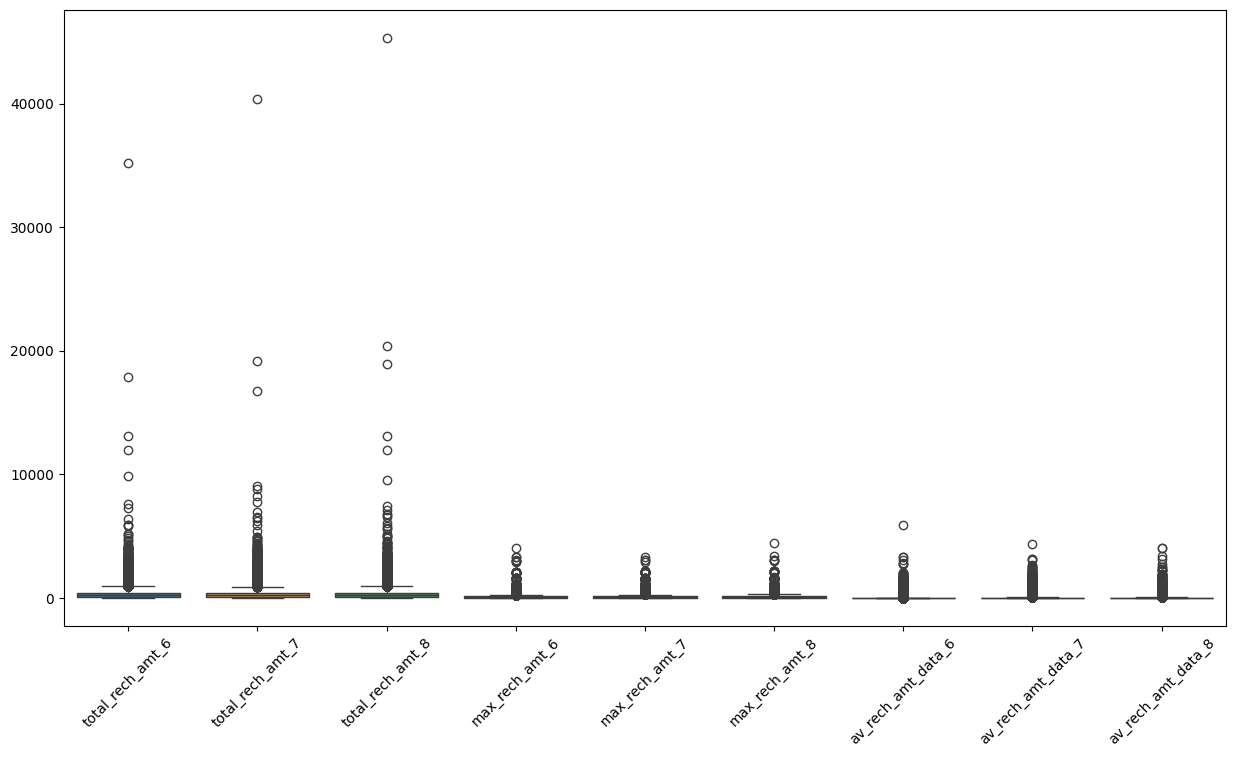

In [ ]:
#check for outliers
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data =rech_amt_df)

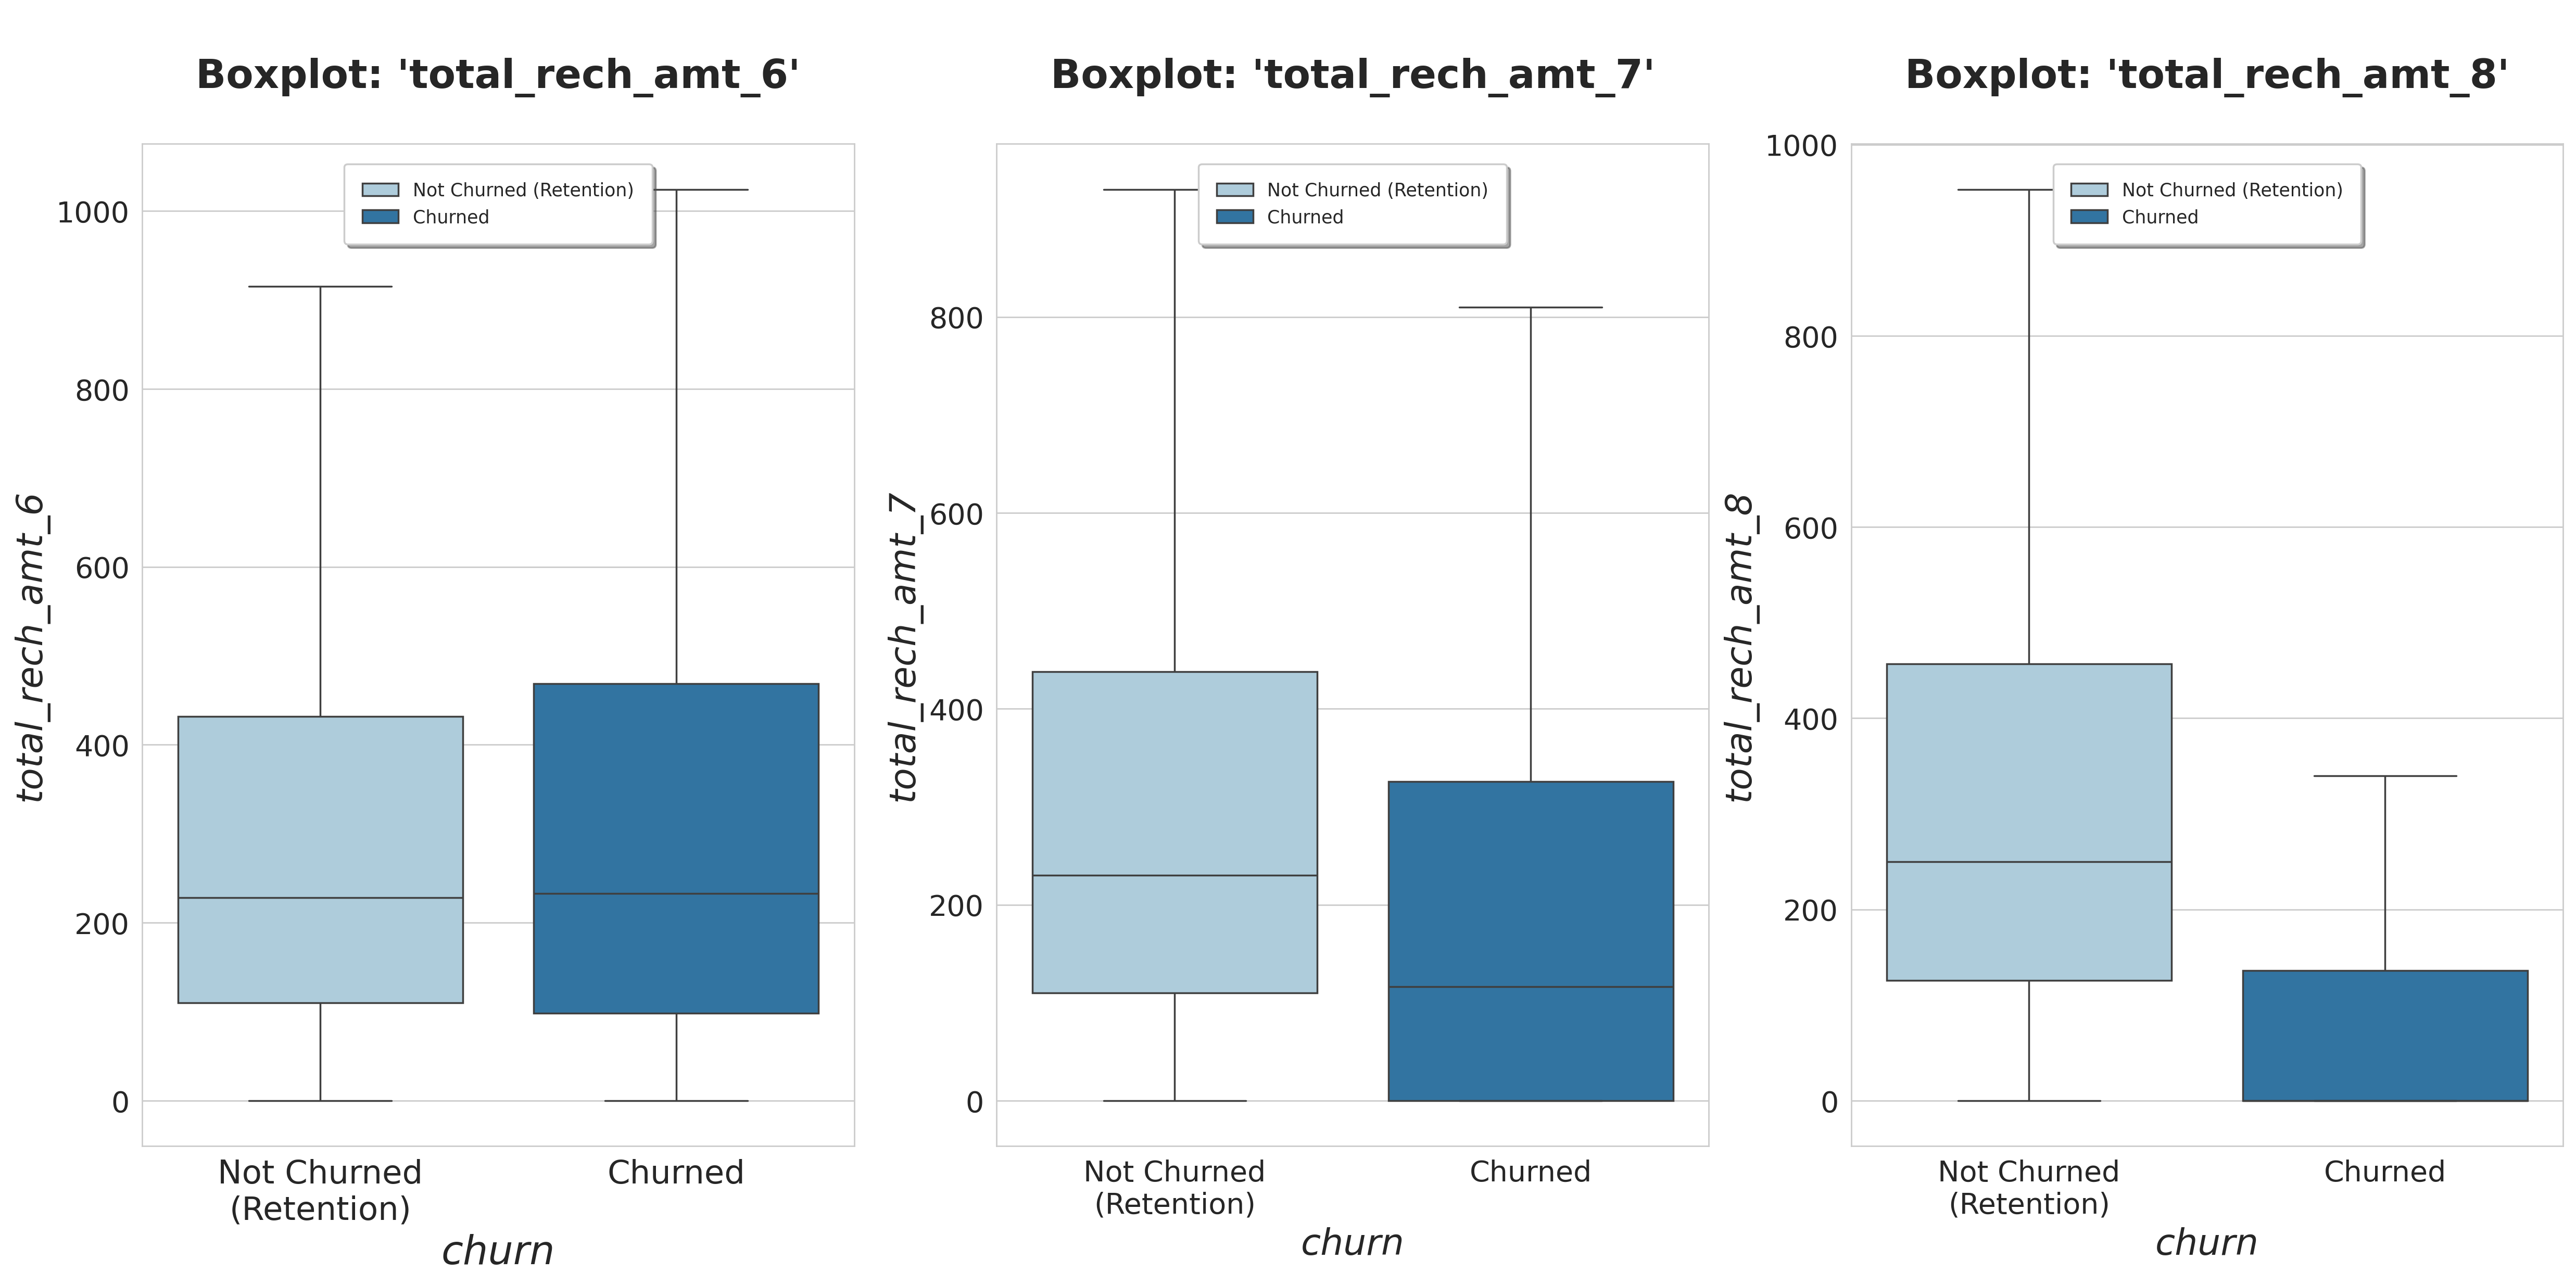

In [ ]:
##Plotting boxplots for 'total_rech_amt' (calling plan recharges)
plot_boxplots_6_7_8('total_rech_amt')

We can see that there is drop in the total recharge amount for churned customers in the 8th Month.

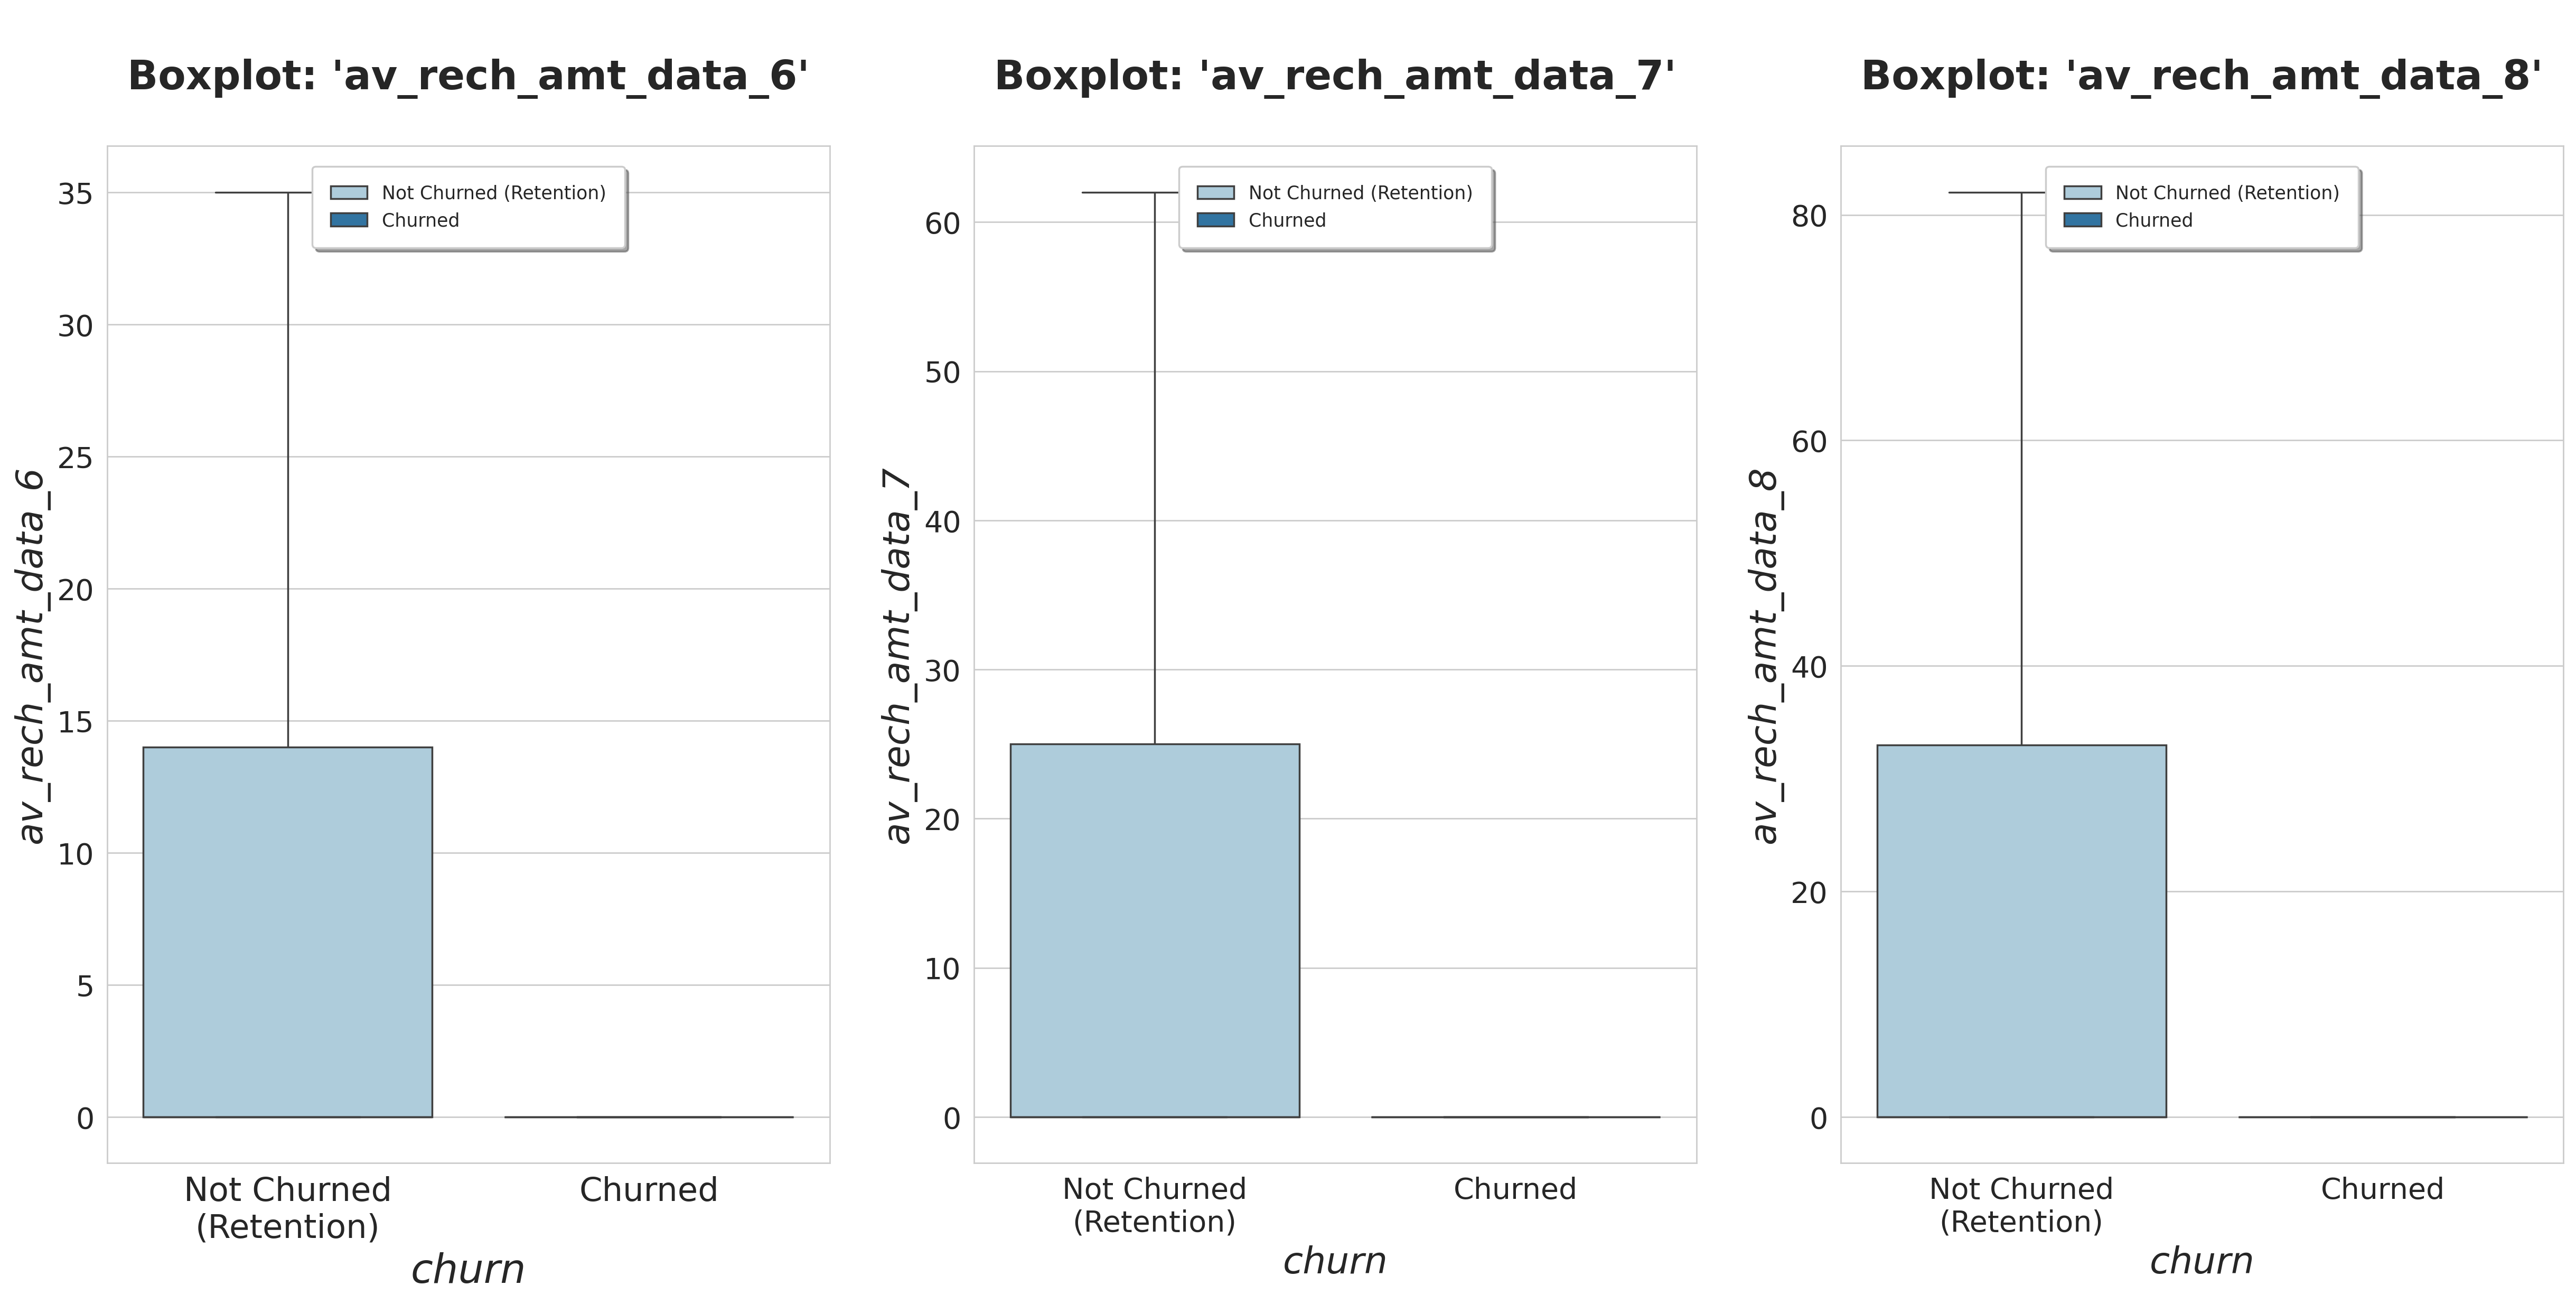

In [ ]:
##Plotting boxplots for 'av_rech_amt_data'
plot_boxplots_6_7_8('av_rech_amt_data')

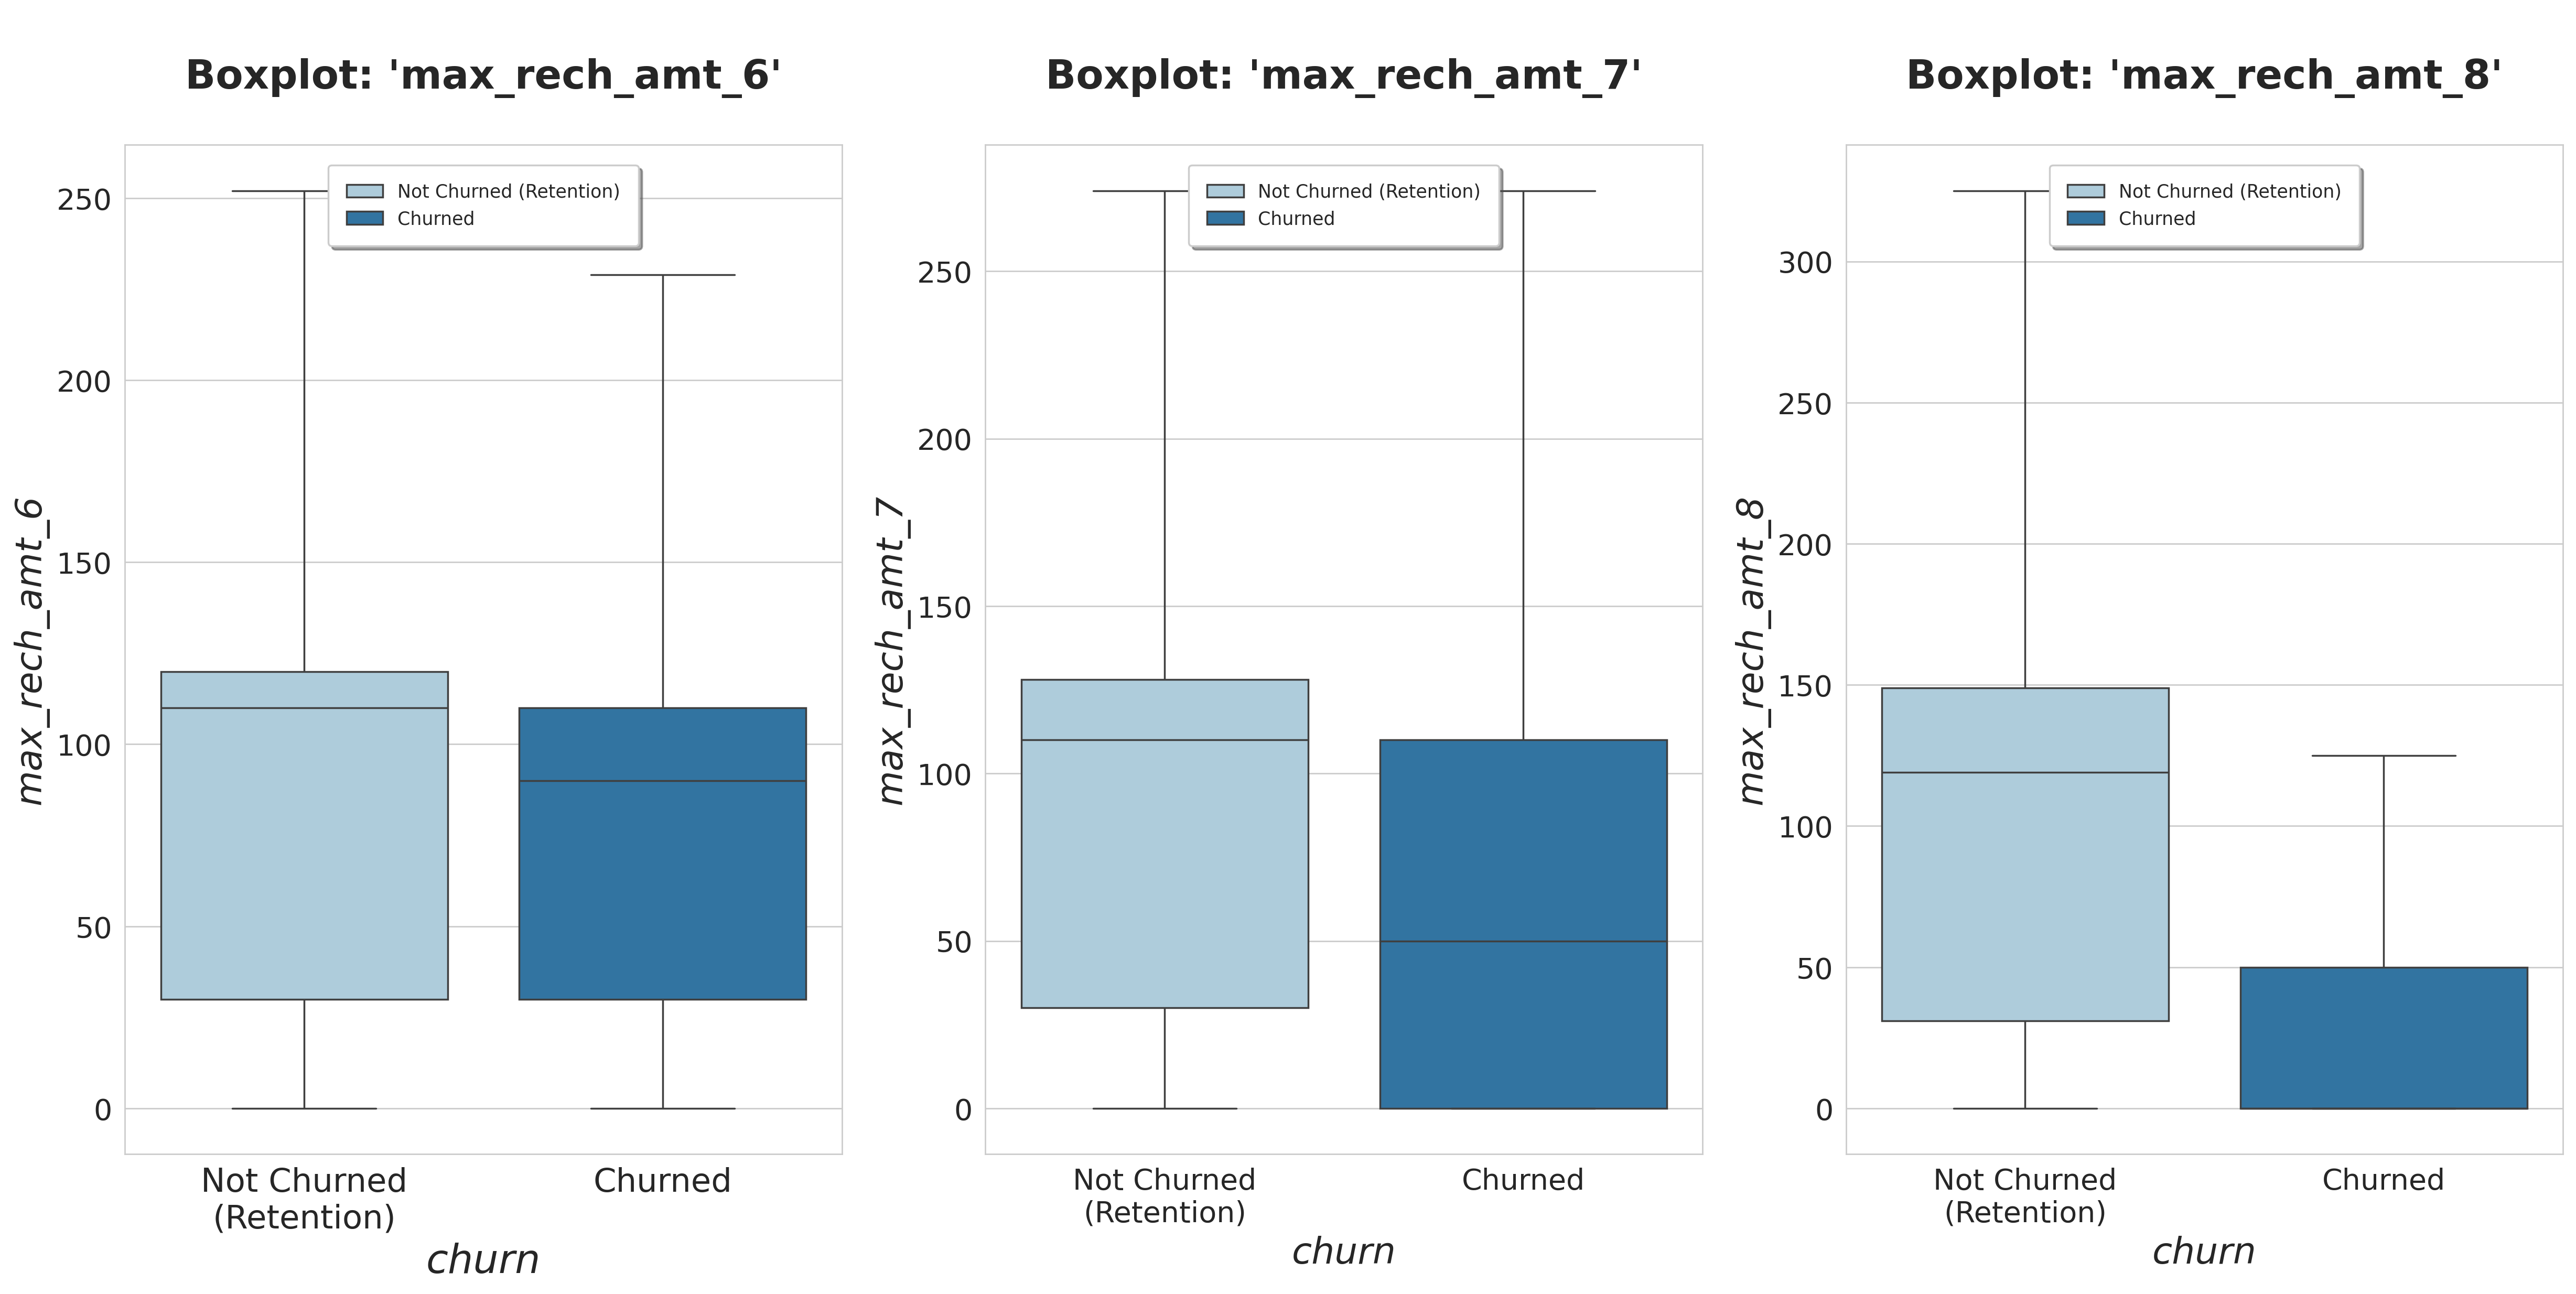

In [ ]:
##Plotting boxplots for 'max_rech_amt'
plot_boxplots_6_7_8('max_rech_amt')

We can saee that there is a drop in the maximum recharge amt for the 8th month churned cutomers

In [ ]:
##Let's check other 'rech_num' and 'max_rech_data' variables
other_rech = telecom_df.columns[telecom_df.columns.str.contains('rech_num|max_rech_data',regex=True)]
other_rech

Index(['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8',
       'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8'],
      dtype='object')

**Do EDA AT THE END**

## Handling the outliers

The box plots of these features show there a lot of outliers. These can be capped with k-sigma method.

In [ ]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

In [ ]:
X_train_filtered1 = X_train.apply(cap_outliers, axis=0)

In [ ]:
X_train_filtered1.head()

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
49209,49209,74.422,136.970,123.993,29.46,42.180000,31.13,18.78,48.51,43.13,0.0,0.0,0.0,0.0,0.0,0.0,23.540000,32.690000,27.09,18.76,48.51,43.13,0.00,0.00,0.00,0.00,0.00,0.00,42.31,81.210000,70.23,5.91,9.48,4.03,0.00,0.00,0.00,0.00,0.0,0.00,5.91,9.48,4.03,0.0,0.00,0.00,0.01,0.000000,0.00,0.0,0.0,0.0,48.24,90.69,74.26,9.780000,28.530000,20.930000,31.48,61.53,53.13,0.00,0.40,4.51,41.26,90.460000,78.580000,31.41,61.94,26.08,0.00,0.00,0.00,0.00,0.00,0.00,31.41,61.94,26.08,73.44,152.640000,105.13,0.556773,0.0,0.0,0.0,0.0,0.00,0.08,0.23,0.46,6.0,9.0,6.0,90.0,150.0,150.0,30.0,30.0,30.0,2014-06-26,2014-07-27,2014-08-28,30.0,30.0,30.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,952.0,0.0,0.0,0.0
9677,9677,287.141,384.323,458.081,563.33,1049.343527,338.01,82.89,43.28,45.33,0.0,0.0,0.0,0.0,0.0,0.0,488.203365,509.029049,338.01,81.06,39.78,44.79,1.83,3.49,0.53,0.00,0.00,0.00,646.23,870.116548,383.34,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.000000,0.00,0.0,0.0,0.0,646.23,1098.13,383.34,35.060000,44.830000,87.860000,231.98,105.49,106.39,3.96,24.81,3.99,271.01,175.140000,198.260000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,271.01,175.140000,198.26,0.000000,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,7.0,6.0,5.0,347.0,477.0,584.0,110.0,110.0,179.0,2014-06-25,2014-07-28,2014-08-28,110.0,110.0,130.0,0.0,0.0,2.0,0.000000,0.000000,179.00000,0.000000,0.000000,324.000000,0.0000,0.000000,107.980000,0.000000,0.000000,772.370000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,1.229019,0.0,0.0,0.0,732.0,614.9,0.0,0.0
66168,66168,665.758,1209.954,1012.179,178.49,224.540000,379.63,187.68,420.84,309.96,0.0,0.0,0.0,0.0,0.0,0.0,54.140000,17.710000,18.61,67.99,66.03,43.84,0.45,2.73,4.53,0.00,0.00,4.45,122.59,86.480000,66.99,124.34,206.83,361.01,118.63,267.74,222.78,0.60,1.9,0.20,243.58,476.48,583.99,0.0,11.59,14

In [ ]:
X_train_copy=X_train_filtered1.copy()

In [ ]:
##Creating  a new column tenure_year to store the number of years the customer has been on network T
X_train_copy['tenure_year'] = round(X_train_copy['aon']/365, 1)

print(X_train_copy.tenure_year.value_counts())
print("Min:",X_train_copy.tenure_year.min())
print("Max:",X_train_copy.tenure_year.max())


tenure_year
1.3     2649
0.6     1996
0.8     1900
1.0     1860
0.9     1845
1.4     1770
0.7     1629
1.2     1611
1.1     1379
1.7     1285
2.0     1252
1.5     1244
0.5     1217
1.8     1199
1.9     1135
2.1     1014
1.6      978
2.4      922
2.2      907
2.3      904
2.6      883
3.0      812
2.5      798
2.9      798
2.8      761
10.0     721
6.5      701
2.7      698
8.5      664
3.1      631
3.2      622
3.3      603
3.4      570
3.6      556
3.5      552
3.7      527
7.1      463
3.9      458
3.8      456
4.6      453
4.0      434
4.2      426
6.6      419
7.9      367
4.7      364
6.9      363
7.6      362
4.3      360
7.0      355
6.2      348
6.8      348
4.1      343
6.4      337
7.5      332
6.7      324
5.5      316
8.0      315
8.1      314
7.8      313
7.2      307
6.1      306
4.4      303
4.5      302
5.4      298
4.9      285
5.0      283
7.7      280
6.3      279
8.8      277
8.4      277
7.4      269
4.8      264
5.7      259
5.8      253
7.3      248
5.3      247


In [ ]:
##Creating bins
my_bins = [0,1,2,3,5,12]
my_labels_aon= ['0_1_year','1_2_year','2_3_year','3_5_year','5_12_year']
X_train_copy['tenure'] = pd.cut(X_train_copy['tenure_year'], bins= my_bins, labels= my_labels_aon)

##Dropping 'tenure_year' and 'aon' column as we have already created bins in 'tenure' column
X_train_copy.drop(['tenure_year','aon'] , axis=1, inplace= True)

X_train_copy.tenure.value_counts()

,count
tenure,
1_2_year,14502
5_12_year,13761
0_1_year,10447
3_5_year,8792
2_3_year,8497


In [ ]:
X_train_copy.head()

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,tenure
49209,49209,74.422,136.970,123.993,29.46,42.180000,31.13,18.78,48.51,43.13,0.0,0.0,0.0,0.0,0.0,0.0,23.540000,32.690000,27.09,18.76,48.51,43.13,0.00,0.00,0.00,0.00,0.00,0.00,42.31,81.210000,70.23,5.91,9.48,4.03,0.00,0.00,0.00,0.00,0.0,0.00,5.91,9.48,4.03,0.0,0.00,0.00,0.01,0.000000,0.00,0.0,0.0,0.0,48.24,90.69,74.26,9.780000,28.530000,20.930000,31.48,61.53,53.13,0.00,0.40,4.51,41.26,90.460000,78.580000,31.41,61.94,26.08,0.00,0.00,0.00,0.00,0.00,0.00,31.41,61.94,26.08,73.44,152.640000,105.13,0.556773,0.0,0.0,0.0,0.0,0.00,0.08,0.23,0.46,6.0,9.0,6.0,90.0,150.0,150.0,30.0,30.0,30.0,2014-06-26,2014-07-27,2014-08-28,30.0,30.0,30.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2_3_year
9677,9677,287.141,384.323,458.081,563.33,1049.343527,338.01,82.89,43.28,45.33,0.0,0.0,0.0,0.0,0.0,0.0,488.203365,509.029049,338.01,81.06,39.78,44.79,1.83,3.49,0.53,0.00,0.00,0.00,646.23,870.116548,383.34,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.000000,0.00,0.0,0.0,0.0,646.23,1098.13,383.34,35.060000,44.830000,87.860000,231.98,105.49,106.39,3.96,24.81,3.99,271.01,175.140000,198.260000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,271.01,175.140000,198.26,0.000000,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,7.0,6.0,5.0,347.0,477.0,584.0,110.0,110.0,179.0,2014-06-25,2014-07-28,2014-08-28,110.0,110.0,130.0,0.0,0.0,2.0,0.000000,0.000000,179.00000,0.000000,0.000000,324.000000,0.0000,0.000000,107.980000,0.000000,0.000000,772.370000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,1.229019,0.0,0.0,0.0,614.9,0.0,0.0,1_2_year
66168,66168,665.758,1209.954,1012.179,178.49,224.540000,379.63,187.68,420.84,309.96,0.0,0.0,0.0,0.0,0.0,0.0,54.140000,17.710000,18.61,67.99,66.03,43.84,0.45,2.73,4.53,0.00,0.00,4.45,122.59,86.480000,66.99,124.34,206.83,361.01,118.63,267.74,222.78,0.60,1.9,0.20,243.58,476.48,583.99,0.0

In [ ]:
X_train_copy.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
Index: 55999 entries, 49209 to 66345
Data columns (total 137 columns):
 #    Column               Dtype         
---   ------               -----         
 0    id                   int64         
 1    arpu_6               float64       
 2    arpu_7               float64       
 3    arpu_8               float64       
 4    onnet_mou_6          float64       
 5    onnet_mou_7          float64       
 6    onnet_mou_8          float64       
 7    offnet_mou_6         float64       
 8    offnet_mou_7         float64       
 9    offnet_mou_8         float64       
 10   roam_ic_mou_6        float64       
 11   roam_ic_mou_7        float64       
 12   roam_ic_mou_8        float64       
 13   roam_og_mou_6        float64       
 14   roam_og_mou_7        float64       
 15   roam_og_mou_8        float64       
 16   loc_og_t2t_mou_6     float64       
 17   loc_og_t2t_mou_7     float64       
 18   loc_og_t2t_mou_8     float64       
 19   loc

In [ ]:
def calculate_recharge_intervals(df):
    """
    Calculate the recharge intervals and average recharge interval.

    Parameters:
    df (pd.DataFrame): DataFrame containing columns 'days_since_rech_6', 'days_since_rech_7', and 'days_since_rech_8'.

    Returns:
    pd.DataFrame: DataFrame with new columns 'rech_interval_6_to_7', 'rech_interval_7_to_8', and 'avg_rech_interval'.
    """
    df['rech_interval_6_to_7'] = df['date_of_last_rech_6'] - df['date_of_last_rech_7']
    df['rech_interval_7_to_8'] = df['date_of_last_rech_7'] - df['date_of_last_rech_8']
    df['avg_rech_interval'] = (df['rech_interval_6_to_7'].dt.days + df['rech_interval_7_to_8'].dt.days) / 2
    df = df.drop(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8','rech_interval_6_to_7','rech_interval_7_to_8'], axis=1)
    return df


In [ ]:
X_train_copy = calculate_recharge_intervals(X_train_copy)

In [ ]:
X_train_copy.head()

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,tenure,avg_rech_interval
49209,49209,74.422,136.970,123.993,29.46,42.180000,31.13,18.78,48.51,43.13,0.0,0.0,0.0,0.0,0.0,0.0,23.540000,32.690000,27.09,18.76,48.51,43.13,0.00,0.00,0.00,0.00,0.00,0.00,42.31,81.210000,70.23,5.91,9.48,4.03,0.00,0.00,0.00,0.00,0.0,0.00,5.91,9.48,4.03,0.0,0.00,0.00,0.01,0.000000,0.00,0.0,0.0,0.0,48.24,90.69,74.26,9.780000,28.530000,20.930000,31.48,61.53,53.13,0.00,0.40,4.51,41.26,90.460000,78.580000,31.41,61.94,26.08,0.00,0.00,0.00,0.00,0.00,0.00,31.41,61.94,26.08,73.44,152.640000,105.13,0.556773,0.0,0.0,0.0,0.0,0.00,0.08,0.23,0.46,6.0,9.0,6.0,90.0,150.0,150.0,30.0,30.0,30.0,30.0,30.0,30.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2_3_year,-31.5
9677,9677,287.141,384.323,458.081,563.33,1049.343527,338.01,82.89,43.28,45.33,0.0,0.0,0.0,0.0,0.0,0.0,488.203365,509.029049,338.01,81.06,39.78,44.79,1.83,3.49,0.53,0.00,0.00,0.00,646.23,870.116548,383.34,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.000000,0.00,0.0,0.0,0.0,646.23,1098.13,383.34,35.060000,44.830000,87.860000,231.98,105.49,106.39,3.96,24.81,3.99,271.01,175.140000,198.260000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,271.01,175.140000,198.26,0.000000,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,7.0,6.0,5.0,347.0,477.0,584.0,110.0,110.0,179.0,110.0,110.0,130.0,0.0,0.0,2.0,0.000000,0.000000,179.00000,0.000000,0.000000,324.000000,0.0000,0.000000,107.980000,0.000000,0.000000,772.370000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,1.229019,0.0,0.0,0.0,614.9,0.0,0.0,1_2_year,-32.0
66168,66168,665.758,1209.954,1012.179,178.49,224.540000,379.63,187.68,420.84,309.96,0.0,0.0,0.0,0.0,0.0,0.0,54.140000,17.710000,18.61,67.99,66.03,43.84,0.45,2.73,4.53,0.00,0.00,4.45,122.59,86.480000,66.99,124.34,206.83,361.01,118.63,267.74,222.78,0.60,1.9,0.20,243.58,476.48,583.99,0.0,11.59,14.26,0.18,69.416985,27.23,0.0,0.0,0.0,366.36,646.74,692.49,22.180000,17.030000,13.580000

In [ ]:
X_train_copy.shape

(55999, 135)

Combination of attributes: Good Phase [month (6) and (7)]

In [ ]:
##Features in X_train_copy corresponding to 'month_6'
attributes_6 = list(X_train_copy.columns[X_train_copy.columns.str.contains("_6")])
print(attributes_6)
print(len(attributes_6))

['arpu_6', 'onnet_mou_6', 'offnet_mou_6', 'roam_ic_mou_6', 'roam_og_mou_6', 'loc_og_t2t_mou_6', 'loc_og_t2m_mou_6', 'loc_og_t2f_mou_6', 'loc_og_t2c_mou_6', 'loc_og_mou_6', 'std_og_t2t_mou_6', 'std_og_t2m_mou_6', 'std_og_t2f_mou_6', 'std_og_mou_6', 'isd_og_mou_6', 'spl_og_mou_6', 'og_others_6', 'total_og_mou_6', 'loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6', 'loc_ic_t2f_mou_6', 'loc_ic_mou_6', 'std_ic_t2t_mou_6', 'std_ic_t2m_mou_6', 'std_ic_t2f_mou_6', 'std_ic_mou_6', 'total_ic_mou_6', 'spl_ic_mou_6', 'isd_ic_mou_6', 'ic_others_6', 'total_rech_num_6', 'total_rech_amt_6', 'max_rech_amt_6', 'last_day_rch_amt_6', 'total_rech_data_6', 'max_rech_data_6', 'av_rech_amt_data_6', 'vol_2g_mb_6', 'vol_3g_mb_6', 'monthly_2g_6', 'sachet_2g_6', 'monthly_3g_6', 'sachet_3g_6']
43


In [ ]:
##Features in X_train_copy corresponding to 'month_7'
attributes_7 = list(X_train_copy.columns[X_train_copy.columns.str.contains("_7")])
print(attributes_7)
print(len(attributes_7))

['arpu_7', 'onnet_mou_7', 'offnet_mou_7', 'roam_ic_mou_7', 'roam_og_mou_7', 'loc_og_t2t_mou_7', 'loc_og_t2m_mou_7', 'loc_og_t2f_mou_7', 'loc_og_t2c_mou_7', 'loc_og_mou_7', 'std_og_t2t_mou_7', 'std_og_t2m_mou_7', 'std_og_t2f_mou_7', 'std_og_mou_7', 'isd_og_mou_7', 'spl_og_mou_7', 'og_others_7', 'total_og_mou_7', 'loc_ic_t2t_mou_7', 'loc_ic_t2m_mou_7', 'loc_ic_t2f_mou_7', 'loc_ic_mou_7', 'std_ic_t2t_mou_7', 'std_ic_t2m_mou_7', 'std_ic_t2f_mou_7', 'std_ic_mou_7', 'total_ic_mou_7', 'spl_ic_mou_7', 'isd_ic_mou_7', 'ic_others_7', 'total_rech_num_7', 'total_rech_amt_7', 'max_rech_amt_7', 'last_day_rch_amt_7', 'total_rech_data_7', 'max_rech_data_7', 'av_rech_amt_data_7', 'vol_2g_mb_7', 'vol_3g_mb_7', 'monthly_2g_7', 'sachet_2g_7', 'monthly_3g_7', 'sachet_3g_7']
43


In [ ]:
##Let's combine and take average of remaining '_6'  and '_7' attributes
feature_names_6 = [i.split('_6')[0] for i in attributes_6 if i.endswith("_6")]
feature_names_7 = [i.split('_7')[0] for i in attributes_7 if i.endswith("_7")]
uncommon_feature_names = [i for i,j in (zip(feature_names_6, feature_names_7)) if i!=j]
uncommon_feature_names

[]

In [ ]:
common_feature_names= [i for i,j in (zip(feature_names_6, feature_names_7)) if i==j]
common_feature_names

['arpu',
 'onnet_mou',
 'offnet_mou',
 'roam_ic_mou',
 'roam_og_mou',
 'loc_og_t2t_mou',
 'loc_og_t2m_mou',
 'loc_og_t2f_mou',
 'loc_og_t2c_mou',
 'loc_og_mou',
 'std_og_t2t_mou',
 'std_og_t2m_mou',
 'std_og_t2f_mou',
 'std_og_mou',
 'isd_og_mou',
 'spl_og_mou',
 'og_others',
 'total_og_mou',
 'loc_ic_t2t_mou',
 'loc_ic_t2m_mou',
 'loc_ic_t2f_mou',
 'loc_ic_mou',
 'std_ic_t2t_mou',
 'std_ic_t2m_mou',
 'std_ic_t2f_mou',
 'std_ic_mou',
 'total_ic_mou',
 'spl_ic_mou',
 'isd_ic_mou',
 'ic_others',
 'total_rech_num',
 'total_rech_amt',
 'max_rech_amt',
 'last_day_rch_amt',
 'total_rech_data',
 'max_rech_data',
 'av_rech_amt_data',
 'vol_2g_mb',
 'vol_3g_mb',
 'monthly_2g',
 'sachet_2g',
 'monthly_3g',
 'sachet_3g']

In [ ]:
#Since all features of '_6' exist in '_7'. Therefore let's find the new 'avg_6_7' features
##(together representing the good phase)

f6_cols=[]
f7_cols=[]
for feature in common_feature_names:
    f6= feature+'_6'
    f7= feature+'_7'
    avg_67= feature+'_avg_6_7'

    f6_cols.append(f6)  ##Storing all remaining attributes from '_6'
    f7_cols.append(f7)  ##Storing all remaining attributes from '_7'

    X_train_copy[avg_67] = (X_train_copy[f6] + X_train_copy[f7])/2

X_train_copy.head()

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,tenure,avg_rech_interval,arpu_avg_6_7,onnet_mou_avg_6_7,offnet_mou_avg_6_7,roam_ic_mou_avg_6_7,roam_og_mou_avg_6_7,loc_og_t2t_mou_avg_6_7,loc_og_t2m_mou_avg_6_7,loc_og_t2f_mou_avg_6_7,loc_og_t2c_mou_avg_6_7,loc_og_mou_avg_6_7,std_og_t2t_mou_avg_6_7,std_og_t2m_mou_avg_6_7,std_og_t2f_mou_avg_6_7,std_og_mou_avg_6_7,isd_og_mou_avg_6_7,spl_og_mou_avg_6_7,og_others_avg_6_7,total_og_mou_avg_6_7,loc_ic_t2t_mou_avg_6_7,loc_ic_t2m_mou_avg_6_7,loc_ic_t2f_mou_avg_6_7,loc_ic_mou_avg_6_7,std_ic_t2t_mou_avg_6_7,std_ic_t2m_mou_avg_6_7,std_ic_t2f_mou_avg_6_7,std_ic_mou_avg_6_7,total_ic_mou_avg_6_7,spl_ic_mou_avg_6_7,isd_ic_mou_avg_6_7,ic_others_avg_6_7,total_rech_num_avg_6_7,total_rech_amt_avg_6_7,max_rech_amt_avg_6_7,last_day_rch_amt_avg_6_7,total_rech_data_avg_6_7,max_rech_data_avg_6_7,av_rech_amt_data_avg_6_7,vol_2g_mb_avg_6_7,vol_3g_mb_avg_6_7,monthly_2g_avg_6_7,sachet_2g_avg_6_7,monthly_3g_avg_6_7,sachet_3g_avg_6_7
49209,49209,74.422,136.970,123.993,29.46,42.180000,31.13,18.78,48.51,43.13,0.0,0.0,0.0,0.0,0.0,0.0,23.540000,32.690000,27.09,18.76,48.51,43.13,0.00,0.00,0.00,0.00,0.00,0.00,42.31,81.210000,70.23,5.91,9.48,4.03,0.00,0.00,0.00,0.00,0.0,0.00,5.91,9.48,4.03,0.0,0.00,0.00,0.01,0.000000,0.00,0.0,0.0,0.0,48.24,90.69,74.26,9.780000,28.530000,20.930000,31.48,61.53,53.13,0.00,0.40,4.51,41.26,90.460000,78.580000,31.41,61.94,26.08,0.00,0.00,0.00,0.00,0.00,0.00,31.41,61.94,26.08,73.44,152.640000,105.13,0.556773,0.0,0.0,0.0,0.0,0.00,0.08,0.23,0.46,6.0,9.0,6.0,90.0,150.0,150.0,30.0,30.0,30.0,30.0,30.0,30.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2_3_year,-31.5,105.6960,35.820000,33.645,0.0,0.0,28.115000,33.635,0.000,0.00,61.760000,7.695,0.000,0.000,7.695,0.000,0.005000,0.0,69.465,19.155000,46.505,0.200,65.860000,46.675,0.00,0.000,46.675,113.040000,0.278387,0.0,0.155,7.5,120.0,30.0,30.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
9677,9677,287.141,384.323,458.081,563

In [ ]:
##Dropping the fundamental explanatory variables belonging to '_6'
X_train_copy.drop(f6_cols, axis=1, inplace=True)

In [ ]:
##Dropping the fundamental explanatory variables belonging to '_7'
X_train_copy.drop(f7_cols, axis=1, inplace=True)

In [ ]:
X_train_copy.head()

,id,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,std_og_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,total_og_mou_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,loc_ic_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,std_ic_mou_8,total_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,tenure,avg_rech_interval,arpu_avg_6_7,onnet_mou_avg_6_7,offnet_mou_avg_6_7,roam_ic_mou_avg_6_7,roam_og_mou_avg_6_7,loc_og_t2t_mou_avg_6_7,loc_og_t2m_mou_avg_6_7,loc_og_t2f_mou_avg_6_7,loc_og_t2c_mou_avg_6_7,loc_og_mou_avg_6_7,std_og_t2t_mou_avg_6_7,std_og_t2m_mou_avg_6_7,std_og_t2f_mou_avg_6_7,std_og_mou_avg_6_7,isd_og_mou_avg_6_7,spl_og_mou_avg_6_7,og_others_avg_6_7,total_og_mou_avg_6_7,loc_ic_t2t_mou_avg_6_7,loc_ic_t2m_mou_avg_6_7,loc_ic_t2f_mou_avg_6_7,loc_ic_mou_avg_6_7,std_ic_t2t_mou_avg_6_7,std_ic_t2m_mou_avg_6_7,std_ic_t2f_mou_avg_6_7,std_ic_mou_avg_6_7,total_ic_mou_avg_6_7,spl_ic_mou_avg_6_7,isd_ic_mou_avg_6_7,ic_others_avg_6_7,total_rech_num_avg_6_7,total_rech_amt_avg_6_7,max_rech_amt_avg_6_7,last_day_rch_amt_avg_6_7,total_rech_data_avg_6_7,max_rech_data_avg_6_7,av_rech_amt_data_avg_6_7,vol_2g_mb_avg_6_7,vol_3g_mb_avg_6_7,monthly_2g_avg_6_7,sachet_2g_avg_6_7,monthly_3g_avg_6_7,sachet_3g_avg_6_7
49209,49209,123.993,31.13,43.13,0.0,0.0,27.09,43.13,0.00,0.00,70.23,4.03,0.00,0.00,4.03,0.00,0.00,0.0,74.26,20.930000,53.13,4.51,78.580000,26.08,0.00,0.00,26.08,105.13,0.0,0.00,0.46,6.0,150.0,30.0,30.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2_3_year,-31.5,105.6960,35.820000,33.645,0.0,0.0,28.115000,33.635,0.000,0.00,61.760000,7.695,0.000,0.000,7.695,0.000,0.005000,0.0,69.465,19.155000,46.505,0.200,65.860000,46.675,0.00,0.000,46.675,113.040000,0.278387,0.0,0.155,7.5,120.0,30.0,30.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
9677,9677,458.081,338.01,45.33,0.0,0.0,338.01,44.79,0.53,0.00,383.34,0.00,0.00,0.00,0.00,0.00,0.00,0.0,383.34,87.860000,106.39,3.99,198.260000,0.00,0.00,0.00,0.00,198.26,0.0,0.00,0.00,5.0,584.0,179.0,130.0,2.0,179.00000,324.000000,107.980000,772.370000,0.0,0.0,1.229019,0.0,614.9,0.0,0.0,1_2_year,-32.0,335.7320,806.336763,63.085,0.0,0.0,498.616207,60.420,2.660,0.00,758.173274,0.000,0.000,0.000,0.000,0.000,0.000000,0.0,872.180,39.945000,168.735,14.385,223.075000,0.000,0.00,0.000,0.000,223.075000,0.000000,0.0,0.000,6.5,412.0,110.0,110.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
66168,66168,1012.179,379.63,309.96,0.0,0.0,18.61,43.84,4.53,4.45,66.99,361.01,222.78,0.20,583.99,14.26,27.23,0.0,692.49,13.580000,110.38,26.51,150.480000,9.68,152.09,0.53,162.31,313.66,0.0,0.86,0.00,16.0,1218.0,144.0,0.0,2.0,98.00000,196.000000,681.605627,0.000000,0.0,2.0,0.000000,0.0,0.0,0.0,0.0,2_3_year,-30.5,937.8560,201.515000,304.260,0.0,0.0,35.925000,67.010,1.590,0.00,104.535000,165.585,193.185,1.250,360.030,5.795,34.798493,0.0,506.550,19.605000,132.810,1.445,153.870000,18.895,98.23,37.535,154.665,308.545000,0.000000,0.0,0.000,18.0,1089.0,132.0,92.0,3.0,126.000000,280.500000,683.668286,0.000000,0.498781,2.5,0.000000,0.0
18280,18280,214.400,98.63,217.66,0.0,0.0,97.16,182.68,5.55,9.56,285.39,1.46,0.00,1.91,3.38,0.00,27.51,0.0,316.29,27.740000,49.21,0.00,76.960000,0.00,0.00,0.00,0.00,80.81,0.0,0.00,3.84,3.0,200.0,200.0,0.0,2.0,268.77938,448.778602,0.000000,1874.686281,0.0,0.0,1.229019,0.0,0.0,0.0,0.0,0_1_year,-30.0,241.6035,100.450000,144.215,0.0,0.0,99.745000,112.560,10.135,3.69,222.450000,0.700,7.725,3.025,11.460,0.000,10.755000,0.0,244.675,12.660000,45.650,0.455,58.775000,0.000,0.00,0.175,0.175,60.860000,0.000000,0.0,1.900,6.5,300.0,200.0,0.0,2.5,263.277012,440.144817,0.000000,1824.212387,0.00000

In [ ]:
X_train_copy.describe(percentiles= [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999])

,id,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,std_og_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,total_og_mou_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,loc_ic_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,std_ic_mou_8,total_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,avg_rech_interval,arpu_avg_6_7,onnet_mou_avg_6_7,offnet_mou_avg_6_7,roam_ic_mou_avg_6_7,roam_og_mou_avg_6_7,loc_og_t2t_mou_avg_6_7,loc_og_t2m_mou_avg_6_7,loc_og_t2f_mou_avg_6_7,loc_og_t2c_mou_avg_6_7,loc_og_mou_avg_6_7,std_og_t2t_mou_avg_6_7,std_og_t2m_mou_avg_6_7,std_og_t2f_mou_avg_6_7,std_og_mou_avg_6_7,isd_og_mou_avg_6_7,spl_og_mou_avg_6_7,og_others_avg_6_7,total_og_mou_avg_6_7,loc_ic_t2t_mou_avg_6_7,loc_ic_t2m_mou_avg_6_7,loc_ic_t2f_mou_avg_6_7,loc_ic_mou_avg_6_7,std_ic_t2t_mou_avg_6_7,std_ic_t2m_mou_avg_6_7,std_ic_t2f_mou_avg_6_7,std_ic_mou_avg_6_7,total_ic_mou_avg_6_7,spl_ic_mou_avg_6_7,isd_ic_mou_avg_6_7,ic_others_avg_6_7,total_rech_num_avg_6_7,total_rech_amt_avg_6_7,max_rech_amt_avg_6_7,last_day_rch_amt_avg_6_7,total_rech_data_avg_6_7,max_rech_data_avg_6_7,av_rech_amt_data_avg_6_7,vol_2g_mb_avg_6_7,vol_3g_mb_avg_6_7,monthly_2g_avg_6_7,sachet_2g_avg_6_7,monthly_3g_avg_6_7,sachet_3g_avg_6_7
count,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000
mean,35000.566528,270.986157,119.139230,184.357947,4.585751,6.782180,39.621664,85.228920,2.906271,1.096569,131.218564,66.178619,73.773645,0.696860,149.146084,0.405416,4.171671,0.007912,287.272760,41.846585,102.120184,9.463075,158.308268,7.401567,16.878241,1.456315,28.655299,187.885078,0.033230,5.327768,0.598135,7.002370,314.722775,103.399240,59.271359,0.610466,31.322887,47.086162,39.440024,112.449082,0.073473,0.365251,0.062889,0.056919,55.707066,53.225287,47.694089,-31.198441,272.496635,119.683450,184.992893,5.786248,8.579618,40.052493,85.746045,3.058142,0.977081,132.400533,66.282807,73.646896,0.743761,149.268040,0.426558,3.731704,0.202331,290.796824,42.106679,100.443586,10.094805,157.525130,7.327684,17.199968,1.531221,28.495636,189.672128,0.041621,5.139371,0.599301,7.421768,315.255092,99.763105,57.950560,0.567936,30.243607,45.118334,40.948460,103.707265,0.072673,0.333026,0.058950,0.052994
std,20210.718993,269.561253,208.467569,235.971736,20.883472,28.457459,74.312129,112.337753,7.353857,3.451883,172.801526,171.665718,173.444731,3.180423,301.909028,4.840779,9.525335,0.179422,382.699422,69.970462,120.578623,22.002178,181.100729,22.321036,39.755278,5.902922,56.680975,221.201054,0.104467,23.870919,3.152813,6.13364

In [ ]:
X_train_copy['tenure'].head()

,tenure
49209,2_3_year
9677,1_2_year
66168,2_3_year
18280,0_1_year
13456,2_3_year


In [ ]:
data_type_counts = X_train_copy.dtypes.value_counts()
print(data_type_counts)

float64     90
int64        1
category     1
Name: count, dtype: int64


In [ ]:
X_train_copy.shape

(55999, 92)

Get dummies for categorical variables:

In [ ]:
#'tenure' is a categorical variable. Converting it into numeric using get_dummies
###Creating dummies for categorical variable 'tenure'
cat_cols= ['tenure']
d_tenure = pd.get_dummies(X_train_copy['tenure'], prefix='tenure', drop_first = True)
X_train_copy = pd.concat([X_train_copy, d_tenure], axis = 1)

##Dropping the 'tenure' column
X_train_copy.drop(cat_cols, axis=1, inplace=True)

# Convert boolean columns to 0 and 1 (if needed)
boolean_cols = d_tenure.columns  # Get the names of the newly created boolean columns
X_train_copy[boolean_cols] = X_train_copy[boolean_cols].astype(int)  # Convert True/False to 1/0

In [ ]:
X_train_copy.head()

,id,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,std_og_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,total_og_mou_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,loc_ic_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,std_ic_mou_8,total_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,avg_rech_interval,arpu_avg_6_7,onnet_mou_avg_6_7,offnet_mou_avg_6_7,roam_ic_mou_avg_6_7,roam_og_mou_avg_6_7,loc_og_t2t_mou_avg_6_7,loc_og_t2m_mou_avg_6_7,loc_og_t2f_mou_avg_6_7,loc_og_t2c_mou_avg_6_7,loc_og_mou_avg_6_7,std_og_t2t_mou_avg_6_7,std_og_t2m_mou_avg_6_7,std_og_t2f_mou_avg_6_7,std_og_mou_avg_6_7,isd_og_mou_avg_6_7,spl_og_mou_avg_6_7,og_others_avg_6_7,total_og_mou_avg_6_7,loc_ic_t2t_mou_avg_6_7,loc_ic_t2m_mou_avg_6_7,loc_ic_t2f_mou_avg_6_7,loc_ic_mou_avg_6_7,std_ic_t2t_mou_avg_6_7,std_ic_t2m_mou_avg_6_7,std_ic_t2f_mou_avg_6_7,std_ic_mou_avg_6_7,total_ic_mou_avg_6_7,spl_ic_mou_avg_6_7,isd_ic_mou_avg_6_7,ic_others_avg_6_7,total_rech_num_avg_6_7,total_rech_amt_avg_6_7,max_rech_amt_avg_6_7,last_day_rch_amt_avg_6_7,total_rech_data_avg_6_7,max_rech_data_avg_6_7,av_rech_amt_data_avg_6_7,vol_2g_mb_avg_6_7,vol_3g_mb_avg_6_7,monthly_2g_avg_6_7,sachet_2g_avg_6_7,monthly_3g_avg_6_7,sachet_3g_avg_6_7,tenure_1_2_year,tenure_2_3_year,tenure_3_5_year,tenure_5_12_year
49209,49209,123.993,31.13,43.13,0.0,0.0,27.09,43.13,0.00,0.00,70.23,4.03,0.00,0.00,4.03,0.00,0.00,0.0,74.26,20.930000,53.13,4.51,78.580000,26.08,0.00,0.00,26.08,105.13,0.0,0.00,0.46,6.0,150.0,30.0,30.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,-31.5,105.6960,35.820000,33.645,0.0,0.0,28.115000,33.635,0.000,0.00,61.760000,7.695,0.000,0.000,7.695,0.000,0.005000,0.0,69.465,19.155000,46.505,0.200,65.860000,46.675,0.00,0.000,46.675,113.040000,0.278387,0.0,0.155,7.5,120.0,30.0,30.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0,1,0,0
9677,9677,458.081,338.01,45.33,0.0,0.0,338.01,44.79,0.53,0.00,383.34,0.00,0.00,0.00,0.00,0.00,0.00,0.0,383.34,87.860000,106.39,3.99,198.260000,0.00,0.00,0.00,0.00,198.26,0.0,0.00,0.00,5.0,584.0,179.0,130.0,2.0,179.00000,324.000000,107.980000,772.370000,0.0,0.0,1.229019,0.0,614.9,0.0,0.0,-32.0,335.7320,806.336763,63.085,0.0,0.0,498.616207,60.420,2.660,0.00,758.173274,0.000,0.000,0.000,0.000,0.000,0.000000,0.0,872.180,39.945000,168.735,14.385,223.075000,0.000,0.00,0.000,0.000,223.075000,0.000000,0.0,0.000,6.5,412.0,110.0,110.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1,0,0,0
66168,66168,1012.179,379.63,309.96,0.0,0.0,18.61,43.84,4.53,4.45,66.99,361.01,222.78,0.20,583.99,14.26,27.23,0.0,692.49,13.580000,110.38,26.51,150.480000,9.68,152.09,0.53,162.31,313.66,0.0,0.86,0.00,16.0,1218.0,144.0,0.0,2.0,98.00000,196.000000,681.605627,0.000000,0.0,2.0,0.000000,0.0,0.0,0.0,0.0,-30.5,937.8560,201.515000,304.260,0.0,0.0,35.925000,67.010,1.590,0.00,104.535000,165.585,193.185,1.250,360.030,5.795,34.798493,0.0,506.550,19.605000,132.810,1.445,153.870000,18.895,98.23,37.535,154.665,308.545000,0.000000,0.0,0.000,18.0,1089.0,132.0,92.0,3.0,126.000000,280.500000,683.668286,0.000000,0.498781,2.5,0.000000,0.0,0,1,0,0
18280,18280,214.400,98.63,217.66,0.0,0.0,97.16,182.68,5.55,9.56,285.39,1.46,0.00,1.91,3.38,0.00,27.51,0.0,316.29,27.740000,49.21,0.00,76.960000,0.00,0.00,0.00,0.00,80.81,0.0,0.00,3.84,3.0,200.0,200.0,0.0,2.0,268.77938,448.778602,0.000000,1874.686281,0.0,0.0,1.229019,0.0,0.0,0.0,0.0,-30.0,241.6035,100.450000,144.215,0.0,0.0,99.745000,112.560,10.135,3.69,222.450000,0.700,7.725,3.025,11.460,0.000,10.755000,0.0,244.675,12.660000,45.650,0.455,58.775000,0.000,0.00,0.175,0.175,60.860000,0.000000,0.0,1.900,6.5,300.0,200.0,0.0,2.5,263.

Feature scaling

In [ ]:
##Creating a function to find binary value columns from the 'telecom_hv' dataframe (if any)
def binary_val_cols(df):
    df_1 = df.copy()
    dualsvcol = (df_1.nunique()==2)
    list_dualsvcol = list(dualsvcol[dualsvcol.values==True].index)
    return list_dualsvcol

binary_cols = binary_val_cols(df= X_train_copy)
print(binary_cols)

['monthly_2g_8', 'tenure_1_2_year', 'tenure_2_3_year', 'tenure_3_5_year', 'tenure_5_12_year']


In [ ]:
##Dataframe with binary columns
X_binary_train = X_train_copy.loc[:, binary_cols]

##Dropping binary dummy variables and we shall concat them later to preserve the scale
X_train_all = X_train_copy.drop(binary_cols, axis=1)

##StandardScaler
from sklearn.preprocessing import StandardScaler
all_cols = X_train_all.columns
scaler = StandardScaler()

#scaler fit_transform on train data
X_train_all[all_cols] = scaler.fit_transform(X_train_all[all_cols])
#concat dummies:Train set
df_train = pd.concat([X_train_all, X_binary_train], axis=1)


In [ ]:
df_train.head()

,id,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,std_og_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,total_og_mou_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,loc_ic_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,std_ic_mou_8,total_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,avg_rech_interval,arpu_avg_6_7,onnet_mou_avg_6_7,offnet_mou_avg_6_7,roam_ic_mou_avg_6_7,roam_og_mou_avg_6_7,loc_og_t2t_mou_avg_6_7,loc_og_t2m_mou_avg_6_7,loc_og_t2f_mou_avg_6_7,loc_og_t2c_mou_avg_6_7,loc_og_mou_avg_6_7,std_og_t2t_mou_avg_6_7,std_og_t2m_mou_avg_6_7,std_og_t2f_mou_avg_6_7,std_og_mou_avg_6_7,isd_og_mou_avg_6_7,spl_og_mou_avg_6_7,og_others_avg_6_7,total_og_mou_avg_6_7,loc_ic_t2t_mou_avg_6_7,loc_ic_t2m_mou_avg_6_7,loc_ic_t2f_mou_avg_6_7,loc_ic_mou_avg_6_7,std_ic_t2t_mou_avg_6_7,std_ic_t2m_mou_avg_6_7,std_ic_t2f_mou_avg_6_7,std_ic_mou_avg_6_7,total_ic_mou_avg_6_7,spl_ic_mou_avg_6_7,isd_ic_mou_avg_6_7,ic_others_avg_6_7,total_rech_num_avg_6_7,total_rech_amt_avg_6_7,max_rech_amt_avg_6_7,last_day_rch_amt_avg_6_7,total_rech_data_avg_6_7,max_rech_data_avg_6_7,av_rech_amt_data_avg_6_7,vol_2g_mb_avg_6_7,vol_3g_mb_avg_6_7,monthly_2g_avg_6_7,sachet_2g_avg_6_7,monthly_3g_avg_6_7,sachet_3g_avg_6_7,monthly_2g_8,tenure_1_2_year,tenure_2_3_year,tenure_3_5_year,tenure_5_12_year
49209,0.703021,-0.545310,-0.422176,-0.598501,-0.21959,-0.238329,-0.168637,-0.374756,-0.395207,-0.317676,-0.352943,-0.362036,-0.425348,-0.219111,-0.480666,-0.083751,-0.437959,-0.044099,-0.556611,-0.298937,-0.406296,-0.225119,-0.440247,0.836816,-0.424557,-0.246713,-0.045435,-0.374120,-0.318096,-0.223193,-0.043814,-0.163423,-0.508265,-0.766244,-0.378778,-0.440408,-0.456754,-0.466974,-0.309684,-0.324676,-0.329780,-0.250405,-0.195827,-0.320373,-0.310838,-0.302244,-0.080469,-0.684812,-0.428090,-0.684529,-0.282112,-0.313973,-0.164114,-0.476191,-0.425860,-0.368487,-0.417662,-0.369896,-0.465986,-0.247809,-0.510572,-0.095284,-0.479661,-0.29136,-0.625124,-0.337177,-0.470436,-0.442015,-0.522372,1.997586,-0.455735,-0.271905,0.341881,-0.361026,2.601515,-0.234344,-0.165604,0.014379,-0.676374,-0.881502,-0.475573,-0.473404,-0.496104,-0.505721,-0.345726,-0.338307,-0.322183,-0.348157,-0.273940,-0.229431,0.0,0,1,0,0
9677,-1.252988,0.694078,1.049913,-0.589177,-0.21959,-0.238329,4.015374,-0.359979,-0.323136,-0.317676,1.459036,-0.385512,-0.425348,-0.219111,-0.494014,-0.083751,-0.437959,-0.044099,0.251028,0.657618,0.035411,-0.248754,0.220607,-0.331599,-0.424557,-0.246713,-0.505559,0.046903,-0.318096,-0.223193,-0.189716,-0.326460,0.830876,0.789227,0.915245,1.002449,2.153445,2.746274,0.538178,1.905398,-0.329780,4.643192,-0.195827,3.215932,-0.310838,-0.302244,-0.213890,0.259617,3.505094,-0.551375,-0.282112,-0.313973,6.304233,-0.231430,-0.055443,-0.368487,3.699876,-0.418478,-0.465986,-0.247809,-0.538323,-0.095284,-0.480304,-0.29136,1.642044,-0.031757,0.595617,0.191649,0.373549,-0.372012,-0.455735,-0.271905,-0.535888,0.157366,-0.457319,-0.234344,-0.223377,-0.169420,0.335130,0.129350,0.885611,-0.473404,-0.496104,-0.505721,-0.345726,-0.338307,-0.322183,-0.348157,-0.273940,-0.229431,0.0,1,0,0,0
66168,1.542138,2.749651,1.249562,0.532281,-0.21959,-0.238329,-0.282751,-0.368436,0.220802,0.971487,-0.371693,1.717489,0.859108,-0.156226,1.440327,2.862082,2.420758,-0.044099,1.058849,-0.403982,0.068502,0.774790,-0.043226,0.102077,3.401132,-0.156926,2.358038,0.568605,-0.318096,-0.187165,-0.189716,1.466943,2.787134,0.423848,-0.766985,1.002449,0.972293,1.476843,5.042301,-0.324676,1.475991,-0.250405,-0.195827,-0.320373,-0.310838,-0.302244,0.186374,2.731682,0.417718,0.539431,-0.282112,-0.313973,-0.056744,-0.171210,-0.204445,-0.368487,-0.164755,0.626947,0.7563

In [ ]:
df_train.shape

(55999, 95)

multicollinearity

In [ ]:
##Rechecking and eliminating those predictor variables that have a correlation of (threshold:-0.7 to 0.7) with other predictors.

df_corr = df_train
my_corr_matrix = df_corr.corr().abs()
my_corr_matrix

upper_triangle = my_corr_matrix.where(np.triu(np.ones(my_corr_matrix.shape), k=1).astype(bool))
cols_to_drop = [col for col in upper_triangle.columns if any(upper_triangle[col] > 0.70)]  #Reduces multicollinearity (if any)
cols_to_drop  #columns to drop from df. Independent predictors highly correlated to each other

['roam_og_mou_8',
 'loc_og_mou_8',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_8',
 'std_og_mou_8',
 'total_og_mou_8',
 'loc_ic_mou_8',
 'std_ic_mou_8',
 'total_ic_mou_8',
 'total_rech_amt_8',
 'av_rech_amt_data_8',
 'vol_3g_mb_8',
 'sachet_2g_8',
 'monthly_3g_8',
 'aug_vbc_3g',
 'jul_vbc_3g',
 'jun_vbc_3g',
 'arpu_avg_6_7',
 'onnet_mou_avg_6_7',
 'offnet_mou_avg_6_7',
 'roam_og_mou_avg_6_7',
 'loc_og_t2t_mou_avg_6_7',
 'loc_og_t2m_mou_avg_6_7',
 'loc_og_t2f_mou_avg_6_7',
 'loc_og_mou_avg_6_7',
 'std_og_t2t_mou_avg_6_7',
 'std_og_t2m_mou_avg_6_7',
 'std_og_mou_avg_6_7',
 'isd_og_mou_avg_6_7',
 'total_og_mou_avg_6_7',
 'loc_ic_t2t_mou_avg_6_7',
 'loc_ic_t2m_mou_avg_6_7',
 'loc_ic_t2f_mou_avg_6_7',
 'loc_ic_mou_avg_6_7',
 'std_ic_t2m_mou_avg_6_7',
 'std_ic_mou_avg_6_7',
 'total_ic_mou_avg_6_7',
 'isd_ic_mou_avg_6_7',
 'total_rech_amt_avg_6_7',
 'max_rech_data_avg_6_7',
 'av_rech_amt_data_avg_6_7',
 'vol_3g_mb_avg_6_7',
 'sachet_2g_avg_6_7',
 'monthly_3g_avg_6_7']

In [ ]:
##Dropping the strongly correlated variables 'cols_to_drop' from 'telecom_hv' dataframe
df_train.drop(cols_to_drop, axis=1, inplace= True)

In [ ]:
df_train.shape

(55999, 51)

Checking for class imbalance

In [ ]:
##Dealing with class imbalance using SMOTE
y= telecom_df['churn_probability']
print("Before OverSampling, counts of label '1'(train_set): {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0'(train_set): {} \n".format(sum(y_train==0)))
print("Before OverSampling, churn event rate (Entire Dataset): {}% \n".format(round(sum(y==1)/len(y)*100,3)))

Before OverSampling, counts of label '1'(train_set): 5690
Before OverSampling, counts of label '0'(train_set): 50309 

Before OverSampling, churn event rate (Entire Dataset): 10.189% 



In [ ]:
from imblearn.combine import SMOTETomek

smote_tomek = SMOTETomek(random_state=42)
X_res, y_res = smote_tomek.fit_resample(df_train, y_train)

print('After OverSampling, the shape of train_X: {}'.format(X_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_res==0)))
print("After OverSampling, churn event rate : {}% \n".format(round(sum(y_res==1)/len(y_res)*100,2)))


After OverSampling, the shape of train_X: (100588, 51)
After OverSampling, the shape of train_y: (100588,) 

After OverSampling, counts of label '1': 50294
After OverSampling, counts of label '0': 50294
After OverSampling, churn event rate : 50.0% 



pca

In [ ]:
#PCA
from sklearn.decomposition import PCA
pca = PCA(random_state=42)
pca.fit(X_res)

PCA(random_state=42)

Components from the PCA

In [ ]:
pca.components_

array([[ 7.42660468e-03,  3.66926617e-01,  1.50689659e-01, ...,
        -2.13308600e-04,  1.02971121e-02,  3.32936041e-02],
       [-1.90576437e-03,  1.24915313e-02,  3.34887777e-02, ...,
         7.27013263e-03, -6.55714886e-03, -4.50446405e-02],
       [ 6.07477081e-03, -7.69657354e-02, -1.92221162e-01, ...,
        -2.67690671e-03, -3.01558445e-03, -7.12123967e-03],
       ...,
       [-9.19784313e-05,  7.90465498e-01, -2.09374526e-01, ...,
         6.75341318e-02,  1.56718871e-02, -1.76074737e-02],
       [-9.42414688e-04,  4.47262169e-02, -2.69029430e-02, ...,
        -4.92426806e-01, -5.99858768e-01, -5.07577658e-01],
       [ 6.77729395e-04, -6.10601475e-03,  3.67650718e-03, ...,
         7.89219069e-03,  1.83850426e-02,  2.04105522e-02]])

In [ ]:
pca.explained_variance_ratio_

array([0.12501878, 0.07232122, 0.06036918, 0.05920251, 0.04179245,
       0.03779299, 0.03706179, 0.03309923, 0.03090933, 0.02927702,
       0.02763926, 0.02645363, 0.02576946, 0.02323657, 0.02228471,
       0.02091264, 0.01993024, 0.01925616, 0.01744614, 0.01677411,
       0.01605713, 0.01519722, 0.01473145, 0.01397877, 0.01366302,
       0.01357069, 0.0125605 , 0.01238601, 0.01136311, 0.01058274,
       0.00999889, 0.00996439, 0.00964648, 0.00846479, 0.00812226,
       0.0076474 , 0.00698177, 0.00668615, 0.00632963, 0.00605857,
       0.0057356 , 0.00542886, 0.00505083, 0.00453799, 0.00403572,
       0.00362007, 0.00340556, 0.00311557, 0.00263573, 0.00134342,
       0.00055224])

Scree Plot Making a scree plot for the explained variance

In [ ]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)

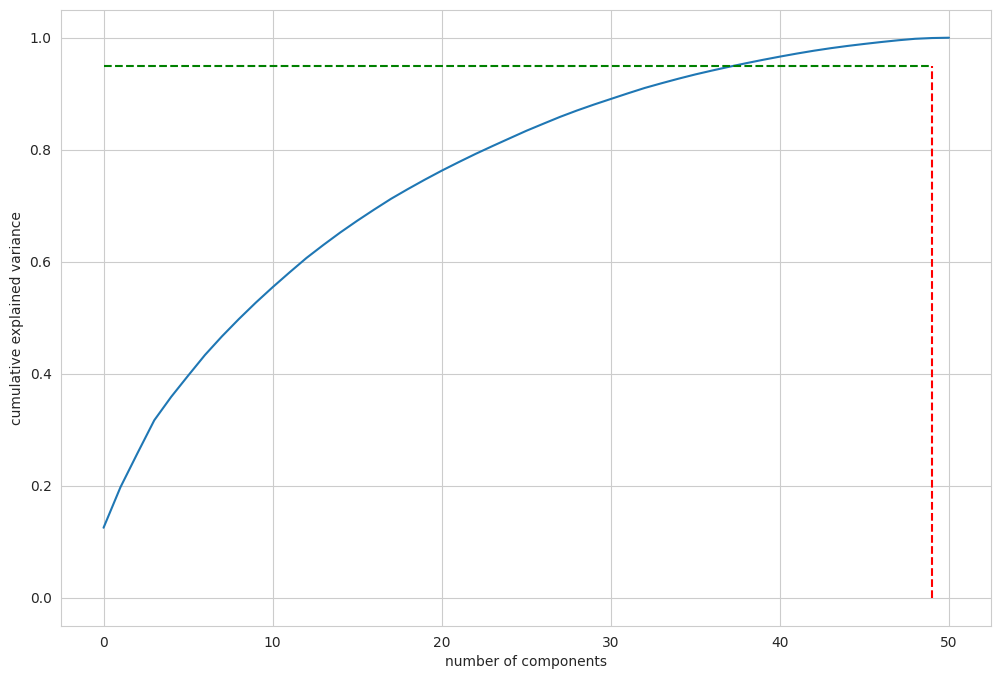

In [ ]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
sns.set_style('whitegrid')
fig = plt.figure(figsize = (12,8))
plt.plot(var_cumu)
plt.hlines(y=0.95, xmax=49, xmin=0, colors="g", linestyles="--")
plt.vlines(x=49, ymax=0.95, ymin=0, colors="r", linestyles="--")  ##Optimal number of features-> 49, explains 95% variance
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [ ]:
#Perform Incremental PCA with 36 components. (Explains 95% variance)

In [ ]:
from sklearn.decomposition import IncrementalPCA
from sklearn import metrics
pca_final = IncrementalPCA(n_components=36)  ##Incremental PCA using 49 components
df_train_pca = pca_final.fit_transform(X_res)  ##fit_transform train set

In [ ]:
df_train_pca.shape

(100588, 36)

<Axes: >

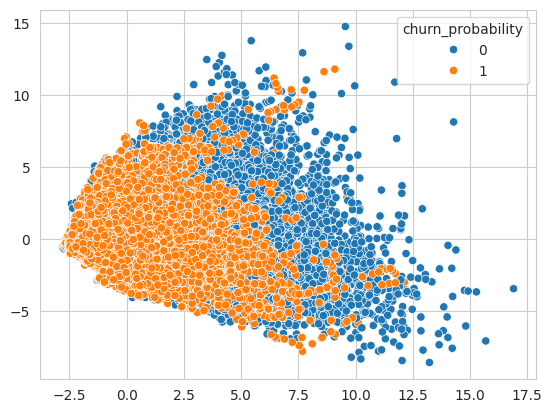

In [ ]:
# Assuming 'y_res' is the target variable corresponding to 'X_res' used for PCA
sns.scatterplot(x=df_train_pca[:,0], y=df_train_pca[:,1], hue=y_res)

<Axes: >

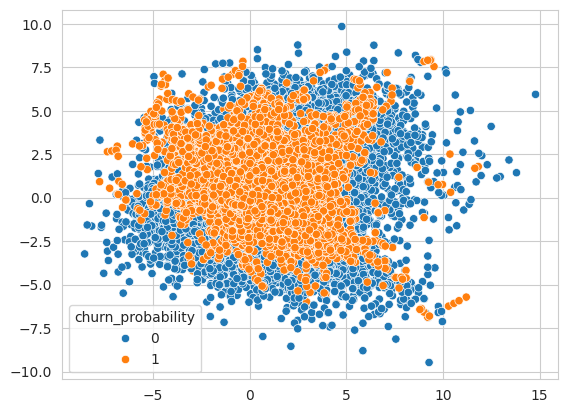

In [ ]:
# Assuming 'y_res' is the target variable corresponding to 'X_res' used for PCA
sns.scatterplot(x=df_train_pca[:,1], y=df_train_pca[:,2], hue=y_res)

In [ ]:
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

# Running the random forest with default parameters.
rfc = RandomForestClassifier()

In [ ]:
# fit
rfc.fit(df_train_pca,y_res)

RandomForestClassifier()

Build a pipeline for X_test data